# VERSION 7

For questions and further information email: samuelgould3@gmail.com

## A markov chain monte carlo polymer simulation with Metropolis rejection rule

Started by partially recreating Lagomarsino paper (doi: 10.1039/c4sm02434f)
- system is made of beads of diameter = $\sigma$
- repulsion between beads is a simple step function
    - energetic penalty for overlap = $p$
- depletion forces are modeled with square-well
    - depth = $\epsilon$
    - size = $a$
- connected by linkers with maximum extension = $\lambda$


## partition function

The probability of occupying state i is given by the partition function, Z, the energy of the system, U, and the Boltzmann factor:

$$P_{i} \propto \frac{\exp(\frac{-U}{kT})}{Z}$$

https://en.wikipedia.org/wiki/Boltzmann_constant#Role_in_the_equipartition_of_energy

The metropolis rejection rule makes it such that I'm sampling the Boltzmann distribution when the polymer is moving around. 
    
## Optimal viewing experience

For optimal viewing experience, use of nbextensions with Table of Contents and code collapsing enabled is reccomended.

# Code

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import save
from numpy import load
import os
from datetime import datetime
import time
#import cv2
import glob
#from natsort import natsorted, ns
import math
import matplotlib.cm as cm
from scipy.stats import truncnorm
from matplotlib.gridspec import GridSpec
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
import pandas as pd

## Basic Functions

In [2]:
def make_circular_connections(positions):
    
    num_points = len(positions)
    
    #keeping connections as a list so that it's more easily manipulated > can always convert to array
    connections = []
    #first case
    connections.append([num_points-1, 1])
    
    for i in range(1, num_points-1):
        connections.append([i-1,i+1])
    #last case
    connections.append([num_points-2, 0])
        
    #output = list of connections for each point
    #i.e. connections[k] = [connections for particle k]
    return connections

In [3]:
def dist_calc(positions, plot=False):
    
    #iterate through particles and calculate distances 
    #> could use np.hypotenuse or some other short-cut function
    
    dist = distance_matrix(positions, positions)
    
    #plot it if desired
    if plot==True:
        
        fig,ax2 = plt.subplots(1,1, figsize=(10,10))
        #plt.figure(figsize=(10,10))
        #plt.gca().set_aspect("equal")      
        
        fig.tight_layout()
        
        ax2 = sns.heatmap(dist, cmap='Reds_r', vmin=0, cbar_kws={'shrink':0.80, 'label': 'distance'})
        ax2.figure.axes[-1].yaxis.label.set_size(20)
        #make heatmpa
        
        ax2.set_aspect(1)
        #plt.colorbar(ax2, cax=cax)

    
    return dist

## Langevin Thermostat (notes + code)

$$\frac{d^2p_{i}}{dt^2} = -\nabla U - \mu \frac{dp_{i}}{dt} + \omega $$

$$p_{i} = \text{position of particle i, } U = \text{potential}, $$

$$\mu = \text{drag coefficient}, \omega = \text{thermal noise term}$$

$\omega$ and $\mu$ are related by a fluctuation-dissipation relationship. $\omega$ is a Gaussian distributed random number with center=0, and whose standard deviation, $$\sigma^2 = 2\mu m_{i}k_{b}T$$
$$\omega \sim N(0,\sigma^2)$$

And further, we can calcualte the drag coefficient, $\mu$ ($\mu = \gamma$ in most texts) by Stokes law, with $\eta$ = viscosity coefficient:

$$\mu = 6\pi \eta r_{i}/m_{i}$$

I'm setting $m_{i} = 1$ and $k_{b} = 1$ for now, though this can be changed. Just makes the numbers neater.

(Most of this is from thermostats.pdf (Brief introduction to the thermostats by Yanxiang zhao))


In [11]:
#viscosity can change as a function of temperature 
#probably not the dominant effect of temperature change though
##NOT YET IMPLEMENTED ## NEED TO FIGURE OUT UNITS, ETC.
def drag_calc(radius, viscosity, mass=1):
    
    #from stoke's thereom for spherical particle
    drag = 6*np.pi*viscosity*radius/mass
    
    return drag
#scalar output

In [12]:
#default set: mass=1, k_b=1
def temp_noise(temperature, drag, num_particles, k_b=1, mass=1, d3=False):
    
    
    ##FOR TIME BEING > SETTING DRAG=1
    
    sd = np.sqrt(2*temperature*drag*k_b*mass)
    
    if d3==False:
        nt = np.random.normal(0, sd, (num_particles, 2))
    
    if d3==True:
        nt = np.random.normal(0, sd, (num_particles, 3))
        
    #output = vector with random noise quantities proportional to temperature
    return nt

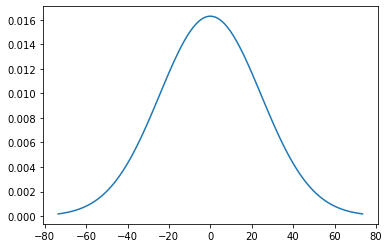

In [17]:
import scipy.stats as stats
import math

drag = 1

mu = 0
variance = 2*300*drag*1*1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

## Acceleration terms (FENE, repulsion, confinement, temp/drag)

In [18]:
def accel_calc(accel, vel, dt, temperature, drag, d3=False, temp=True):
    
    #calculate langevin motion
    #STARTING WITH ENSEMBLE WHERE (Nabla)U = 0 everywhere (all step functions)
    
    #could just input num_beads instead > more efficient than checking list size?
    num_particles = len(accel)
    
    if temp==True:
        if d3==False:
            t_noise = temp_noise(temperature, drag, num_particles, d3=False)
        if d3==True:
            t_noise = temp_noise(temperature, drag, num_particles, d3=True)
    
    #no temp-associated noise
    if temp==False:
        t_noise = np.zeros(np.shape(accel))
        
    vel_damp = vel*drag  
    
    
    #making acceleration not added to previous acceleration term
    accel_new = t_noise - vel_damp
    
    return (accel_new + accel)

In [2]:
def spring_accel(positions, distances, connect_size, diam, k, temperature, k_b=1):
    
    #r_0 = resting length for spring = connect_size (lambda)/2
    r_0 = diam + (connect_size-diam)/2 #(could be changed)
    dr_max = (connect_size-diam)/2 #such that balls dont overlap + maximal extension size = connect_size
    
    num_beads = len(positions)
    i = np.diag(distances, k=1)
    ii = np.diag(distances, k=num_beads-1)
    dist_con = np.concatenate((ii, i, ii))
    
    circ_pos = np.vstack((positions[num_beads-1], positions, positions[0]))

    accel_spring = []
    for i in range(1,num_beads+1):
        #v_1 = k*(unit connect vector)*(abs(∆x))
        dx_1 = dist_con[i-1]-r_0
        v_1 = k*((circ_pos[i-1]-circ_pos[i])/dist_con[i-1])*dx_1 #=Hookean component #k_b*temperature*
        v_1_FENE = v_1 / (1 - (dx_1**2/(dr_max**2))) # = v_1 / (1 - (∆x^2)/(∆rmax^2))
        
        dx_2 = dist_con[i]-r_0
        v_2 = k*((circ_pos[i+1]-circ_pos[i])/dist_con[i])*dx_2 #k_b*temperature*
        v_2_FENE = v_2 / (1 - (dx_2**2/(dr_max**2)))
        
        sum_v = v_1_FENE + v_2_FENE 
        accel_spring.append(sum_v)
        
    
    return np.asarray(accel_spring)
    
    

if time is an issue with this sort of searching, i can look at:

https://stackoverflow.com/questions/33281957/faster-alternative-to-numpy-where



In [1]:
def nonadjacent_bonds(NAB_matrix, positions, distances, connect_size, diam, k, temperature, k_b=1):
    "For calculating spring force of tethers/NABs"
    
    #NAB_matrix = sparse, upper triangular matrix containing non_adjacent bonds (1 = bond; 0 = no bond)
    NAB_pairs = np.asarray(np.where(NAB_matrix==1)).T
    #len(NAB_pairs) = number of NAB 
    
    #r_0 = resting length for spring = connect_size (lambda)/2
    r_0 = 1.75*diam #(could be changed)
    dr_max = (connect_size-diam)/2 #such that balls dont overlap + maximal extension size = connect_size
    
    NAB_accel = np.zeros(positions.shape)
    NAB_en = 0
    if len(NAB_pairs)>0:
        for i in NAB_pairs:
            dist_bw = distances[i[0]][i[1]]
            dx = dist_bw - r_0
            
            p_0 = positions[i[0]]
            p_1 = positions[i[1]]
            
            #refer to page 86 of lab notebook for FENE details
            vec_0 = ((p_1 - p_0)/dist_bw)*k*dx #unit vector*k*dx
            vec_1 = -vec_0
            
            scaling_FENE = 1/(1 - (dx**2/(dr_max**2)))
            
            NAB_accel[i[0]] = vec_0*scaling_FENE
            NAB_accel[i[1]] = vec_1*scaling_FENE
            
            NAB_en += -0.5*k*((dr_max)**2)*np.log(1 - (dx/dr_max)**2)
    
    #need to remove bonded pairs from repulsive acceleration component > can simply subtract NAB_matrix from repulse_accel

    return NAB_accel, NAB_en

In [52]:
def repulse_accel(NAB_matrix, other_accel, num_beads, positions, distances, diam, temperature, k_b=1):
    "Calculation of non-adjacent monomer repulsion"

    dist = distances #dist_calc(positions)
    #excluding adjacent monomers (dealth with by FENE)
    dist_1 = dist + np.diag(5*np.ones(num_beads), k=0) + np.diag(np.diag(dist, k=1), k=1) + np.diag(np.diag(dist, k=1), k=-1)+ np.diag([dist[0][num_beads-1]], k=num_beads-1) + np.diag([dist[0][num_beads-1]], k=1-num_beads)
    cutoff = diam*1.5 #diam*2**(1/6) #could change this cutoff if needed
    filtered = np.triu(np.where(dist_1 < cutoff, 1, 0))

    filtered_2 = filtered-NAB_matrix #excluding NAB
        
    nonzero = np.nonzero(filtered_2)
    nonzero_pairs = np.vstack((nonzero[0], nonzero[1])).T

    en=0
    if len(nonzero_pairs)>0:
        empty_accel = np.zeros(np.shape(positions))

        diam=1

        for i, val in enumerate(nonzero_pairs):

            dist_bw = distances[val[0]][val[1]]

            p_0 = positions[val[0]]
            p_1 = positions[val[1]]

            #calculate unit vectors + directionality
            n = 6 # how much repulsion?
            scaling = abs((n*(diam**n))/((dist_bw - diam)**(n+1)))
            ##CALCULATE THIS > MAYBE CALC ENERGY AT SAME TIME???
            energy = (diam/(dist_bw-diam))**n #avoid doubling the energy?? 
            en += energy

            u_0 = scaling*((p_0 - p_1) / dist_bw) 
            u_1 = scaling*((p_1 - p_0) / dist_bw)

            empty_accel[val[0]] = empty_accel[val[0]] + u_0
            empty_accel[val[1]] = empty_accel[val[1]] + u_1
        
        repulsive_energy = en
        
        return (empty_accel + other_accel), repulsive_energy
    
    else:
        repulsive_energy=0
        return other_accel, repulsive_energy

In [54]:
def confinement_accel(other_accel, conf_radius, num_beads, positions, diam, shaft_length, cap=True):
    #adding capping as an option (cap=True: spherocylindrical confinement; cap=False: infinite cylindrical confinement)
    
    #starting with cylinder of infinite length > add spherocylindrical caps afterward
    positions_xy = positions[:,0:2]
    cutoff = diam*1.5 #diam*(2**(1/6)) - diam #I think this makes sense

    dist_o = np.linalg.norm(positions_xy, axis=1) 
    diff = conf_radius - (diam/2) - dist_o #find distance between edge of monomer and edge of cylinder = (r-diam) equivalent
    conf = np.where(diff < cutoff, diff, 0) #cutoff = where acceleration starts to occur
    
    if cap==True:
        #need to exclude these from cylindrical repulsion
        positions_z = positions[:,2]
        s = shaft_length/2
        positions_z_edges = abs(positions_z) + diam/2 #this gives the exterior positions of the beads, accounting for size of bead
        past_z = np.where(positions_z_edges>s, 1, 0)
        #get indeces of nonzero values
        past_z_indeces = np.nonzero(past_z)
        c_to_e_cyl = np.nonzero(conf)
        
        #removing indeces that pass the z threshold so that they don't get a cylindrical confinement accel component
        A = c_to_e_cyl[0]
        B = past_z_indeces[0]
        
        if len(B)>0:
            sidx = B.argsort()
            idx = np.searchsorted(B,A,sorter=sidx)
            idx[idx==len(B)] = 0
            close_to_edge_cyl = A[B[sidx[idx]] != A]

        else:
            close_to_edge_cyl = A
        #close_to_edge_cyl = A[B[np.searchsorted(B,A)] !=  A] #this doesn't account for possibility that A is larger than B
        
    else:
        close_to_edge_cyl = np.nonzero(conf)[0]
    
    #empty arrays to fill
    accel_conf = np.zeros(np.shape(positions))
    conf_energy=0
    n = 6 # how much repulsion? -- keep consistent with monomer-monomer repulsion
    
    for i in (close_to_edge_cyl):
        p = -positions_xy[i]/dist_o[i] #generate unit vector pointing from point towards x,y origin
        scaling = abs((n*(diam**n))/((diff[i])**(n+1)))
        p_scaled = p*scaling
        accel_conf[i] += np.asarray([p_scaled[0], p_scaled[1], 0]) #z-component of vector field = 0

        ##CALC ENERGY AT SAME TIME???
        energy = (diam/(diff[i]))**n #avoid doubling the energy?? 
        conf_energy += energy
    
    if cap==True:
        #first sort indeces by top or bottom
        top = []
        bottom = []
        for i in B: #B = array of indeces where Z is past the value
            if positions_z[i]> (s - diam/2):
                top.append(i)
            if positions_z[i]< (-s + diam/2):
                bottom.append(i)
        
        t_ori = np.asarray([0,0,s])
        b_ori = np.asarray([0,0,-s])
        for j in top:
            dist = np.linalg.norm(positions[j]-t_ori)
            diff = conf_radius - (dist + diam/2) #distance from edge of sphere to edge of wall
            if diff < cutoff:
                p = (t_ori - positions[j])/dist
                scaling = abs((n*(diam**n))/((diff)**(n+1)))
                p_scaled = p*scaling
                accel_conf[j] += p_scaled 
                
                energy = (diam/(diff))**n #avoid doubling the energy?? 
                conf_energy += energy
                
        for j in bottom:
            dist = np.linalg.norm(positions[j]-b_ori)
            diff = conf_radius - (dist + diam/2) #distance from edge of sphere to edge of wall
            if diff < cutoff: 
                p = (b_ori - positions[j])/dist
                scaling = abs((n*(diam**n))/((diff)**(n+1)))
                p_scaled = p*scaling
                accel_conf[j] += p_scaled 
                
                energy = (diam/(diff))**n #avoid doubling the energy?? 
                conf_energy += energy
    
    return (accel_conf + other_accel), conf_energy

    

## Velocity (verlet) & position calc.

In [57]:
def pos_calc(positions, vel, dt):
    
    positions_new = positions + (vel*dt)
    
    return positions_new

In [58]:
#using velocity verlet form
def verlet_pos_calc(positions, vel_prev, accel, dt):
    
    positions_new = positions + (vel_prev*dt) + 0.5*accel*(dt**2)
    
    return positions_new

## Energy calculation

In [59]:
def U_calc(NAB_en, repulse_energy, conf_energy, positions, dist, num_beads, diam, pen, pen_con, connect_size, e, a, k,
           temperature, k_b=1, circ=True, conf=True):
    
#    positions = positions.reshape((num_beads, 2))  #FOR OPTIMIZATION > 1d/flattened array
    
    #first calculate distance matrix
    #dist = dist_calc(positions)
   # dist = distances
    u_tri = np.triu(dist)

    # identity upper triangular matrix with diagonal entries=0 
    identity_ut = np.triu(np.ones((num_beads,num_beads)))
    np.fill_diagonal(identity_ut, 0)
    
##_______________________________MONOMER REPULSION_______________________________##
    
    #take u_tri and use it to calculate U_repulsive and U_attractive
    u_rep = u_tri - ((diam)*identity_ut)
    #NEED TO ADD e to pen otherwise depletion forces act during bead overlap
    u_repulsive = np.sum(np.where(u_rep < 0, 1, 0))*(pen-e)*k_b*temperature + repulse_energy
    
##_______________________________DEPLETION_______________________________##
    
    #getting rid of contribution of adjacent monomers > no depletion force
    diag_1 = np.diag(u_tri, 1)
    diag_2 = np.diag(u_tri, (num_beads-1))
    mat_diag_1 = np.diag(diag_1, 1) + np.diag(diag_2,(num_beads-1))
    identity_ut_2 = identity_ut - np.diag(np.ones(num_beads-1),1) - np.diag([1], (num_beads-1))
    
    u_att = (u_tri-mat_diag_1) - (a*identity_ut_2)
    u_attractive = np.sum(np.where(u_att < 0, 1, 0))*e*k_b*temperature #e < 0
    
##_______________________________CONNECTIONS_______________________________##
    #now calculate u_connections
    #calculating a flattened array for each of the connection distances
    if circ==True:
        i = np.diag(u_tri, k=1)
        ii = np.diag(u_tri, k=num_beads-1)
        flat_c_length = np.concatenate((i, ii))

        u_con = flat_c_length - connect_size*np.ones(num_beads)
        u_connections = np.sum(np.where(u_con > 0, 1, 0))*pen_con*k_b*temperature 
    
    if circ==False:
        i = np.diag(u_tri, k=1)
        flat_c_length = i

        u_con = flat_c_length - connect_size*np.ones(num_beads-1)
        u_connections = np.sum(np.where(u_con > 0, 1, 0))*pen_con*k_b*temperature 
    
    
##_______________________________ELASTICITY OF CONNECTIONS (new)___________________________## 

#adding in elastic omponent to connections so there's energy associated with 
#assuming Circ=True; can change later
    
    #from above, take the distance between each of the connections
    #say that the natural connection length (u=0) is equal to 1/2 max connect_size (lam)
    r_0 = diam + (connect_size-diam)/2
    dr_max = (connect_size-diam)/2
    
    d_x = (flat_c_length - (r_0)*np.ones(num_beads)) #(r-r_0)
    u_elastic = np.log(np.ones(num_beads) - (d_x/dr_max)**2) #ln(1- (∆x/∆r_max)^2)
    
    #switched to FENE
    spring_cons = k #(units of kbt)
    u_con_spring = -0.5*(spring_cons)*((dr_max)**2)*np.sum(u_elastic) #*k_b*temperature
    
    #not sure if it's right to scale the spring constant here and not scale it in the calculation of force vector
    #could just add it into the force vector


##_______________________________CONFINEMENT_______________________________##
    
    u_total = u_repulsive + u_attractive + u_connections + u_con_spring + conf_energy + NAB_en
    
    return u_total  #, u_con_spring, u_repulsive, u_attractive, u_connections, u_elastic

#COULD be better to return all of these, so that I know which terms are dominating the potential

## metropolis rejection rule

In [80]:
def metropolis_rule(U_prev, U_curr, temperature, k_b=1):
    
    if U_curr < U_prev: 
        return True
    
    else:
        dU = U_curr-U_prev
        boltzmann = np.e**(-dU/(k_b*temperature))
        out = np.random.choice([True,False],p=np.asarray([boltzmann,(1-boltzmann)]))
        
        #true = accept
        #false = reject
        
        return out
        

## Dynamic non-adjacent tethers/crosslinks

The general idea is to install or release a crosslink as a function of distance. The current set distance for tethers is equal to $$r_{0, tethers} = 1.75\sigma_{H}$$

There should be an allowable range within which I can let tethers be installed (to avoid breaking simulation by choosing FENE distance that is ridiculously close). E.g. 1.9,1.5

The probabiliyt 

I should only compute it every 1,000 time steps 

I should have a variable for the sparseness of allowable connection points -- could do this by choosing a random number in addition to probability of 

How could I calculate loss of tethers such that there is cycling? Simply start by having a certain probabiity of losing tethers that is constant over time. 

Need to be saving NAB_matrices as well with thousandth parameter calculation
+Need to graph change in connectivity over time with the 

In [81]:
def dynamic_tethering(curr_NABmatrix, positions, p_loss, p_form, cutoff_dist, hns_loading):
    "dynamically install and release tethers; parameters refer to likelihood of installation or release"

    #CUTOFF DISTANCE = A
    a=cutoff_dist

    ###--------------------------First decide which of existing tethers to lose (if any)------------------------##
    
    new_NABmatrix = np.copy(curr_NABmatrix)
    
    #Choose whether to lose tethers first???
    NAB_curr = np.asarray(np.where(curr_NABmatrix==1)).T
    for i in NAB_curr:
        
        p = np.asarray([p_loss, (1-p_loss)])
        lose = np.random.choice([True, False], p=p)
        
        if lose==True:
            new_NABmatrix[i[0]][i[1]]=0
        else:
            continue
    
    
     ###--------------------------Then deciding which tethers (if any) to add------------------------##
    
    dist = dist_calc(positions)
    u_tri = np.triu(dist)

    # identity upper triangular matrix with diagonal entries=0 
    num_beads = len(positions)
    identity_ut = np.triu(np.ones((num_beads,num_beads)))
    np.fill_diagonal(identity_ut, 0)

    diag_1 = np.diag(u_tri, 1)
    diag_2 = np.diag(u_tri, (num_beads-1))
    mat_diag_1 = np.diag(diag_1, 1) + np.diag(diag_2,(num_beads-1))
    identity_ut_2 = identity_ut - np.diag(np.ones(num_beads-1),1) - np.diag([1], (num_beads-1))

    #u_attractive output is non-adjacent monomers that are less than 1.9 units apart (1=under cutoff; 0=not)
    u_att = (u_tri-mat_diag_1) - (a*identity_ut_2)
    u_attractive = np.where(u_att < 0, 1, 0)

    #now getting rid of existing NAB_pairs
    crosslink_candidates = u_attractive-curr_NABmatrix

    #DEPENDING ON VALUE OF a, THERE COULD BE NEGATIVE VALUES IN CROSSLINK_CANDIDATES > SHOULDN'T MATTER
    NAB_potential = np.asarray(np.where(crosslink_candidates==1)).T
    
    
    ##Choosing which monomers are allowed to form connections based on hns_loading
    p2 = np.asarray([hns_loading, (1-hns_loading)])
    allowable_links = np.random.choice([True,False], size=num_beads, p=p2)
    
    #choose whether to form a tether
    for i in NAB_potential:
        
        if allowable_links[i[0]] and allowable_links[i[1]] == True:
            #probability criterion > should include "HNS loading"
        
            #preventing multiple tethers on one monomer
             #if these bonds don't currently have tethers
            if sum(new_NABmatrix[i[0]]) + sum(new_NABmatrix[i[1]]) + sum(new_NABmatrix.T[i[0]]) + sum(new_NABmatrix.T[i[1]]) == 0:
            
                p1 = np.asarray([p_form, (1-p_form)])
                form = np.random.choice([True, False], p=p1)

                #minimum distance = 1.55 (true min = 1.5)
                if dist[i[0]][i[1]]<1.55:
                    form=False
                
                if form==True:
                    new_NABmatrix[i[0]][i[1]] = 1
                
        else:
            continue

    return new_NABmatrix

In [152]:
def dynamic_tethering_FEEDBACK(curr_NABmatrix, positions, p_loss, p_form, max_tethers, cutoff_dist, hns_loading):
    "dynamically install and release tethers; parameters refer to likelihood of installation or release"

    #CUTOFF DISTANCE = A
    a=cutoff_dist
    new_NABmatrix = np.copy(curr_NABmatrix)
#    curr_num_tethers = np.sum(np.sum(curr_NABmatrix))
    
    ###--------------------------Start by adding tethers------------------------##
    
    dist = dist_calc(positions)
    u_tri = np.triu(dist)

    # identity upper triangular matrix with diagonal entries=0 
    num_beads = len(positions)
    identity_ut = np.triu(np.ones((num_beads,num_beads)))
    np.fill_diagonal(identity_ut, 0)

    diag_1 = np.diag(u_tri, 1)
    diag_2 = np.diag(u_tri, (num_beads-1))
    mat_diag_1 = np.diag(diag_1, 1) + np.diag(diag_2,(num_beads-1))
    identity_ut_2 = identity_ut - np.diag(np.ones(num_beads-1),1) - np.diag([1], (num_beads-1))

    #u_attractive output is non-adjacent monomers that are less than 1.9 units apart (1=under cutoff; 0=not)
    u_att = (u_tri-mat_diag_1) - (a*identity_ut_2)
    u_attractive = np.where(u_att < 0, 1, 0)

    #now getting rid of existing NAB_pairs
    crosslink_candidates = u_attractive-curr_NABmatrix

    #DEPENDING ON VALUE OF a, THERE COULD BE NEGATIVE VALUES IN CROSSLINK_CANDIDATES > SHOULDN'T MATTER
    NAB_potential = np.asarray(np.where(crosslink_candidates==1)).T
    
    
    ##Choosing which monomers are allowed to form connections based on hns_loading
    p2 = np.asarray([hns_loading, (1-hns_loading)])
    allowable_links = np.random.choice([True,False], size=num_beads, p=p2)
    
    #choose whether to form a tether
    for i in NAB_potential:
        
        if allowable_links[i[0]] and allowable_links[i[1]] == True:
            #probability criterion > should include "HNS loading"
        
            #preventing multiple tethers on one monomer
             #if these bonds don't currently have tethers
            if sum(new_NABmatrix[i[0]]) + sum(new_NABmatrix[i[1]]) + sum(new_NABmatrix.T[i[0]]) + sum(new_NABmatrix.T[i[1]]) == 0:
            
                p1 = np.asarray([p_form, (1-p_form)])
                form = np.random.choice([True, False], p=p1)

                #minimum distance = 1.55 (true min = 1.5)
                if dist[i[0]][i[1]]<1.55:
                    form=False
                
                if form==True:
                    new_NABmatrix[i[0]][i[1]] = 1
                
        else:
            continue
    
    ###--------------------------Now breaking tethers------------------------##
    
    #check how many tethers are now present
    num_tethers = np.sum(np.sum(new_NABmatrix))
    if num_tethers>max_tethers:
        p_loss=1
        #FEEDBACK LOOP > BREAK ALL TETHERS IF YOU EXCEED MAX
    
    else:
        p_loss=p_loss
    
    
    NAB_curr = np.asarray(np.where(new_NABmatrix==1)).T
    for i in NAB_curr:
        
        p = np.asarray([p_loss, (1-p_loss)])
        lose = np.random.choice([True, False], p=p)
        
        if lose==True:
            new_NABmatrix[i[0]][i[1]]=0
        else:
            continue
    

    return new_NABmatrix

## input/ouput (file naming)

In [98]:
#pen = penalty for overlap
#include confinement?????
#conf_description = description of confinement


#confTrue
#confFalse
from datetime import datetime
def npy_namer(pen, connect_size, e, a, dt, run_time, 
              temperature, drag, k, conf_radius_init, conf_radius_final, shaft_length_init, shaft_length_final,
             p_loss, p_form, cutoff_dist, hns_loading, label=None):
    
    date_time = str(datetime.now())
    date_time_2 = date_time.replace(":", "_")
    
    if label==None:
        name = 'lam' + str(connect_size) + '_e' + str(e) + '_a' + str(a) + '_dt' + str(dt) + '_T' + str(temperature) + '_drag' + str(drag) +'_k' + str(k) + '_cradi' + str(conf_radius_init) + '_cradf' + str(conf_radius_final) +  '_sleni' + str(shaft_length_init) + '_slenf' + str(shaft_length_final) + '_ploss' + str(p_loss)  + '_pform' + str(p_form) + '_cutoff'+ str(cutoff_dist) + '_hnsloading' +  str(hns_loading) +  '_' + date_time_2 + '.npy'
    
    else:
        name = label + 'lam' + str(connect_size) + '_e' + str(e) + '_a' + str(a) + '_dt' + str(dt) + '_T' + str(temperature) + '_drag' + str(drag) +'_k' + str(k) + '_cradi' + str(conf_radius_init) + '_cradf' + str(conf_radius_final) +  '_sleni' + str(shaft_length_init) + '_slenf' + str(shaft_length_final) + '_ploss' + str(p_loss)  + '_pform' + str(p_form) + '_cutoff'+ str(cutoff_dist) + '_hnsloading' +  str(hns_loading) +  '_' + date_time_2 + '.npy'
    
    #for both of these cases, i need to explicity state the file path for windows version
    #file path
    path = os.getcwd()
    
    #issue is with the naming of the file, not in path description
    full_name = path + '\\' + name
    #print(full_name)
    
    return name


In [99]:
dt =.0001
temperature = 300
conf_radius_init = 10
conf_radius_final = 20
shaft_length_init = 5
shaft_length_final = 4
diam = 1 #radius=diam/2
    #pen, pen_con, e are in units of k_b*t
pen = 100000 #penalty for overlap and for moving past connection size
    #hard spheres; hard connection size
pen_con = 100000 #LET"S MAKE IT DISALLOWED
connect_size = 1.5 #=lambda = maximal connection size
e = -2 #energetic benefit of depletion forces
a = 1.75 #=diameter of depletion force square well (min distance between centers for depletion)
conf_radius = 6 #radius of infinite cylinder containing polymer
k = 100 #spring constant > units of k_bt???
drag = 1 #this should be replaced by function of temperature and viscosity
run_time = 5e5
p_loss = 0.5
cutoff_dist = 1.9
p_form = .1
hns_loading = .5
label='poop_'
    
npy_namer(pen, connect_size, e, a, dt, run_time, 
              temperature, drag, k, conf_radius_init, conf_radius_final, shaft_length_init, shaft_length_final,
             p_loss, p_form, cutoff_dist, hns_loading)

'lam1.5_e-2_a1.75_dt0.0001_T300_drag1_k100_cradi10_cradf20_sleni5_slenf4_ploss0.5_pform0.1_cutoff1.9_hnsloading0.5_2021-02-10 11_19_46.833443.npy'

In [100]:
def csv_writer(time, u, num_rej, p, v, a, full_name):
    
    num_beads = len(p)
    p_num = np.arange(0, num_beads)
    t = np.ones(num_beads)*time
    U = np.ones(num_beads)*u
    nr = np.ones(num_beads)*num_rej #need to deal with fact that num_rej = N/A for initial position
    
    df = pd.DataFrame([t,U,nr,p_num, p[:,0],p[:,1],p[:,2], 
                   v[:,0],v[:,1],v[:,2], a[:,0],a[:,1],a[:,2]]).T
    df.columns = ['t','U','num_rej','particle_num','p_x','p_y','p_z','v_x','v_y','v_z','a_x','a_y','a_z']
    
    if t[0]==0:
        df.to_csv(full_name, mode='a+', index=False, encoding="utf-16")
    else:
        df.to_csv(full_name, mode='a+', header=False,index=False, encoding="utf-16")
        #with open(full_name, 'a+') as f:
            #df.to_csv(f, mode='a+', header=False, index=False, encoding="utf-16")
            
            
        #seemed like the issue had to do with not closing the file after opening it?? not sure but this method works

In [101]:
#note> file_names need to be taken from jupyter (finder converts : > / for some reason)
def csv_reader(file):
    #read in file
    path = os.getcwd()
    full_name = path + '\\' + file
    df1 = pd.read_csv(full_name, encoding="utf-16")
    
    #get information about number of beads, etc. from file name
    x = file.split('_') #splits the file name by '_' > allows for parsing > useful in future
    num_beads = int(''.join(filter(str.isdigit, x[0])))
#    run_time = int(''.join(filter(str.isdigit, x[7]))) #breaks if run_time =! completed
    
    #run_time = length of data frame/num_beads
    run_time = int(len(df1)/num_beads)
    
    #loading in the pos, vel, accel, etc.
    pp = np.stack((np.asarray(df1['p_x']),np.asarray(df1['p_y']),
               np.asarray(df1['p_z'])), axis=1)
    vv = np.stack((np.asarray(df1['v_x']),np.asarray(df1['v_y']),
               np.asarray(df1['v_z'])), axis=1)
    aa = np.stack((np.asarray(df1['a_x']),np.asarray(df1['a_y']),
               np.asarray(df1['a_z'])), axis=1)
    
    
    #reshape such that pos, vel, accel are indexed by time-step
    pos = pp.reshape(run_time, num_beads, 3)
    vel = vv.reshape(run_time, num_beads, 3)
    accel = aa.reshape(run_time, num_beads, 3)
    
   #get u and rc
    uu = np.asarray(df1['U'])
    U = uu[0::num_beads]
    
    rr = np.asarray(df1['num_rej'])
    rej_count = rr[0::num_beads]
    
    
    return U, pos, vel, accel, rej_count

## Structure Initialization

Code for initializing fractal structure to be compressed. Also including "G2" figure-8 topology misc.

In [26]:
def rot(c, phi):
    "c = array to rotate; phi = rotation angle"
    R_z = np.asarray([[-np.cos(phi), np.sin(phi), 0],[np.sin(phi), np.cos(phi), 0], [0,0,1],])
    d = c @ R_z.T
    
    return d

In [27]:
def plotter123(d, scat=False):
    plt.figure(figsize=(10,10))
    if scat==True:
        plt.scatter(d[:,0],d[:,1], c='r', s=100, alpha=0.25)
    for i in range(len(d)-1):
        plt.plot([d[i][0], d[i+1][0]], [d[i][1], d[i+1][1]], c='b')    

    plt.plot([d[0][0], d[-1][0]],[d[0][1], d[-1][1]], c= 'b')
    
    
    plt.xlim(np.min(d[:,0]-2),np.max(d[:,0]+2))
    plt.ylim(np.min(d[:,1]-2),np.max(d[:,1]+2))

In [29]:
unit_perp = 1.25
unit_45 = unit_perp*np.cos(np.pi/4)

a = np.asarray([[5*unit_45, -unit_45, 0],[4*unit_45, 0, 0], [3*unit_45, -unit_45, 0], [2*unit_45, -2*unit_45, 0], [unit_45, -unit_45, 0],
                [0,0,0],[unit_45, unit_45, 0], [2*unit_45, 2*unit_45, 0], [2*unit_45, 2*unit_45 + unit_perp, 0],
               [2*unit_45, 2*unit_45 + 2*unit_perp, 0],[3*unit_45, 3*unit_45 + 2*unit_perp, 0],
                
               [4*unit_45 , 2*unit_45 + 2*unit_perp, 0],[4*unit_45 + 1*unit_perp, 2*unit_45 + 2*unit_perp, 0],
                [4*unit_45 + 2*unit_perp, 2*unit_45 + 2*unit_perp, 0], [5*unit_45 + 2*unit_perp, 3*unit_45 + 2*unit_perp, 0],
                [5*unit_45 + 2*unit_perp, 3*unit_45 + 3*unit_perp, 0],[4*unit_45 + 2*unit_perp, 4*unit_45 + 3*unit_perp, 0],
                [4*unit_45 + 1*unit_perp, 4*unit_45 + 3*unit_perp, 0], [4*unit_45, 4*unit_45 + 3*unit_perp, 0],
                [3*unit_45, 3*unit_45 + 3*unit_perp, 0],[2*unit_45, 4*unit_45 + 3*unit_perp, 0], 
                [2*unit_45, 4*unit_45 + 4*unit_perp, 0], [2*unit_45, 4*unit_45 + 5*unit_perp, 0],
                
                [2*unit_45, 4*unit_45 + 6*unit_perp, 0], [3*unit_45, 5*unit_45 + 6*unit_perp, 0],
                [4*unit_45, 4*unit_45 + 6*unit_perp, 0], [4*unit_45 + unit_perp, 4*unit_45 + 6*unit_perp, 0], 
                [4*unit_45 + 2*unit_perp, 4*unit_45 + 6*unit_perp, 0], [5*unit_45 + 2*unit_perp, 5*unit_45 + 6*unit_perp, 0],
                [5*unit_45 + 2*unit_perp, 5*unit_45 + 7*unit_perp, 0], [4*unit_45 + 2*unit_perp, 6*unit_45 + 7*unit_perp, 0],
                [4*unit_45 + 1*unit_perp, 6*unit_45 + 7*unit_perp, 0], [4*unit_45, 6*unit_45 + 7*unit_perp, 0],
                [3*unit_45, 5*unit_45 + 7*unit_perp, 0],
                [2*unit_45, 6*unit_45 + 7*unit_perp, 0], [2*unit_45, 6*unit_45 + 8*unit_perp, 0],
                
                [2*unit_45, 6*unit_45 + 9*unit_perp, 0], [1*unit_45, 7*unit_45 + 9*unit_perp, 0],
                [0,8*unit_45 + 9*unit_perp, 0],
    
                
                ])

a2 = a.copy()

#mirror across y-axis to get b
b = []
for i in reversed(a2):
    vec = i
    vec[0] = -i[0]
    b.append(vec)


b2 = np.asarray(b) - np.asarray([1.25,0,0])
connector = np.asarray([-1.25,a[-1][1], 0])

c = np.vstack((a, b2)) + np.asarray([unit_perp/2,5.5*unit_perp,0])
c_minus_ends = c[1:len(c)-1]

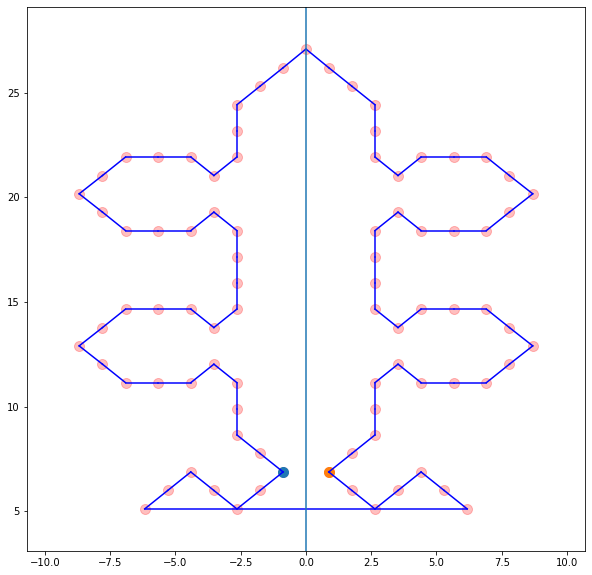

In [30]:
y_05 = 1.75/2
x_05 = np.sqrt(1.25**2 - (1.75/2)**2)

hex_correct_x = 1.6660897716523297/2
hex_correct_y = np.sqrt(1.25**2 - (1.6660897716523297/2)**2)

a = np.asarray([[6*unit_45, -2*unit_45, 0],[5*unit_45, -unit_45, 0],[4*unit_45, 0, 0], [3*unit_45, -unit_45, 0], [2*unit_45, -2*unit_45, 0], [unit_45, -unit_45, 0],
                [0,0,0],[unit_45, unit_45, 0], [2*unit_45, 2*unit_45, 0], [2*unit_45, 2*unit_45 + unit_perp, 0],
               [2*unit_45, 2*unit_45 + 2*unit_perp, 0],[3*unit_45, 3*unit_45 + 2*unit_perp, 0],
               
                [4*unit_45 , 2*unit_45 + 2*unit_perp, 0],[4*unit_45 + 1*unit_perp, 2*unit_45 + 2*unit_perp, 0],
                [4*unit_45 + 2*unit_perp, 2*unit_45 + 2*unit_perp, 0], [5*unit_45 + 2*unit_perp, 3*unit_45 + 2*unit_perp, 0],
               [5*unit_45 + 2*unit_perp + x_05, 3*unit_45 + 2*unit_perp + y_05, 0]])

aaa = np.asarray([[5*unit_45 + 2*unit_perp, 3*unit_45 + 3*unit_perp, 0],[4*unit_45 + 2*unit_perp, 4*unit_45 + 3*unit_perp, 0],
                [4*unit_45 + 1*unit_perp, 4*unit_45 + 3*unit_perp, 0],[4*unit_45, 4*unit_45 + 3*unit_perp, 0],
                [3*unit_45, 3*unit_45 + 3*unit_perp, 0],[2*unit_45, 4*unit_45 + 3*unit_perp, 0], 
                [2*unit_45, 4*unit_45 + 4*unit_perp, 0], [2*unit_45, 4*unit_45 + 5*unit_perp, 0],
                
                [2*unit_45, 4*unit_45 + 6*unit_perp, 0], [3*unit_45, 5*unit_45 + 6*unit_perp, 0],
                [4*unit_45, 4*unit_45 + 6*unit_perp, 0], [4*unit_45 + unit_perp, 4*unit_45 + 6*unit_perp, 0],
                  
                [4*unit_45 + 2*unit_perp, 4*unit_45 + 6*unit_perp, 0], [5*unit_45 + 2*unit_perp, 5*unit_45 + 6*unit_perp, 0],
                [5*unit_45 + 2*unit_perp + x_05, 5*unit_45 + 6*unit_perp + y_05, 0]
                
                ]) + np.asarray([0,0.5,0])

aaaa = np.asarray([[5*unit_45 + 2*unit_perp, 5*unit_45 + 7*unit_perp, 0], [4*unit_45 + 2*unit_perp, 6*unit_45 + 7*unit_perp, 0],
                [4*unit_45 + 1*unit_perp, 6*unit_45 + 7*unit_perp, 0], [4*unit_45, 6*unit_45 + 7*unit_perp, 0],
                [3*unit_45, 5*unit_45 + 7*unit_perp, 0],
                [2*unit_45, 6*unit_45 + 7*unit_perp, 0], [2*unit_45, 6*unit_45 + 8*unit_perp, 0],
                
                [2*unit_45, 6*unit_45 + 9*unit_perp, 0], [1*unit_45, 7*unit_45 + 9*unit_perp, 0],
                [0,8*unit_45 + 9*unit_perp, 0], [-y_05,8*unit_45 + 9*unit_perp+x_05, 0]]) + np.asarray([0,1,0])
               
a1234 = np.vstack((a,aaa,aaaa)) + np.asarray([y_05,0,0])

a2 = a1234.copy()

#mirror across y-axis to get b
b = []
for i in reversed(a2):
    vec = i
    vec[0] = -i[0]
    b.append(vec)


b2 = np.asarray(b)
connector = np.asarray([-1.25,a1234[-1][1], 0])

c = np.vstack((a1234, b2[1:])) + np.asarray([0,5.5*unit_perp,0])
c_minus_ends = c[1:len(c)-1]
    
#plotter123(a1234, scat=True)
#plotter123(b2, scat=True)
plotter123(c, scat=True)
plt.scatter(c[-7][0], c[-7][1], s=100)
plt.scatter(c[6][0], c[6][1], s=100)
plt.plot([0,0],[1,30])
#plt.xlim(-1,1)

1.2499999999999964 1.2633247286554328


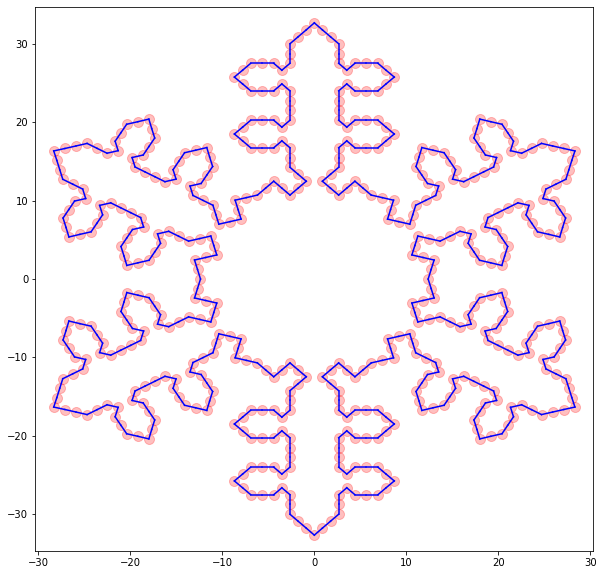

In [34]:
#c2 = np.vstack((a1234, b2[1:])) + np.asarray([unit_perp/2,7.7*unit_perp,0])
#c2 = np.vstack((a1234, b2[1:])) + np.asarray([unit_perp/2+.12,10*unit_perp,0])
c2 = np.vstack((a1234, b2[1:])) + np.asarray([0,9.98615*unit_perp,0])
c2_minus_ends = c2[1:len(c2)-1]

phi = 2*np.pi/3
d = rot(c2_minus_ends, phi*5)*np.asarray([1,-1,1])
dd = rot(c2, phi*4)*np.asarray([-1,1,1])

e = rot(c2_minus_ends, np.pi)*np.asarray([-1,1,1])

f = rot(c2, phi*2)*np.asarray([-1,1,1])
ff = rot(c2_minus_ends, phi)*np.asarray([1,-1,1])

g2 = np.vstack((c2,d, dd, e, f,ff))#,dd, e,f, ff))
plotter123(g2, scat=True)
len(g2)
print(np.min(np.diag(dist_calc(g2), k=1)), np.max(np.diag(dist_calc(g2), k=1)))

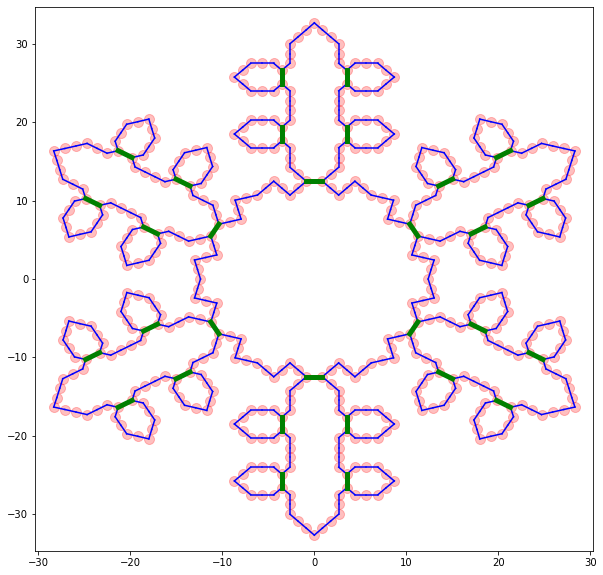

In [136]:
NAB_matrix_1 = np.zeros((len(g2),len(g2)))

NAB_matrix_1[6][78] = 1
NAB_matrix_1[11][21] = 1
NAB_matrix_1[26][36] = 1
NAB_matrix_1[48][58] = 1
NAB_matrix_1[63][73] = 1

#NAB_matrix_1[72+10][82+67] = 1


i2 = 90
i3 = 90+72+12
i4 = 90+72*2+12*2
i5 = 90+72*3+12*3
i6 = 90+72*4+12*4
i_list = [i2,i3,i4,i5,i6]
for i in i_list:
    NAB_matrix_1[i][i+72] = 1
    NAB_matrix_1[i+5][i+15] = 1
    NAB_matrix_1[i+20][i+30] = 1
    NAB_matrix_1[i+42][i+52] = 1
    NAB_matrix_1[i+57][i+67] = 1


NAB_pairs = np.asarray(np.where(NAB_matrix_1==1)).T
NAB_pairs

plotter123(g2, scat=True)
for i in NAB_pairs:
    plt.plot([g2[i[0]][0],g2[i[1]][0]], [g2[i[0]][1],g2[i[1]][1]], c='g', linewidth=5)

In [43]:
import nxviz as nxv
import networkx as nx

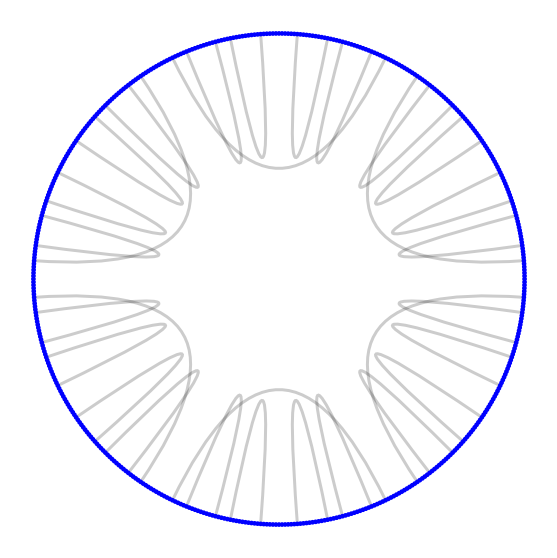

In [44]:
G = nx.Graph()
a = range(len(NAB_matrix_1))
G.add_nodes_from(a)

NAB_pairs = np.asarray(np.where(NAB_matrix_1==1)).T
NAB_pairs

#and add edges
for i in NAB_pairs:
    e = (i[0],i[1])
    G.add_edge(*e)
    
ew = 3 #edgewidth

G_circos = nxv.CircosPlot(G, node_labels=None,
                            edge_width=list(ew*np.ones(len(NAB_pairs))), 
                            figsize=(10,10))
G_circos.draw()

info on nxviz use
https://thejoeblankenship.com/blogs/networkx/networkx.html

In [45]:
NAB_matrix_ex = np.zeros((len(ex_pos), len(ex_pos)))
NAB_matrix_ex[0][9] = 1
NAB_matrix_ex[10][8] = 1
NAB_matrix_ex[7][3] = 1
NAB_matrix_ex[10][2] = 1
NAB_matrix_ex[17][0] = 1

G = nx.Graph()
a = range(len(NAB_matrix_ex))
G.add_nodes_from(a)

NAB_pairs = np.asarray(np.where(NAB_matrix_ex==1)).T
NAB_pairs

#and add edges
for i in NAB_pairs:
    e = (i[0],i[1])
    G.add_edge(*e)

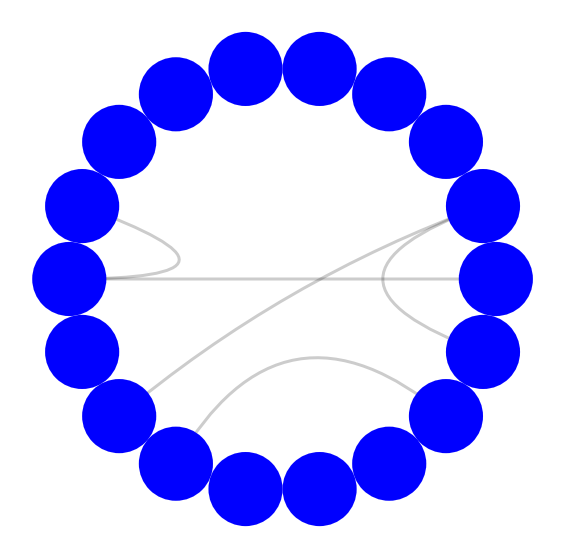

In [46]:
ew = 3 #edgewidth

G_circos = nxv.CircosPlot(G, node_labels=None, 
                            edge_width=list(ew*np.ones(len(NAB_pairs))), 
                            figsize=(10,10))
G_circos.draw()

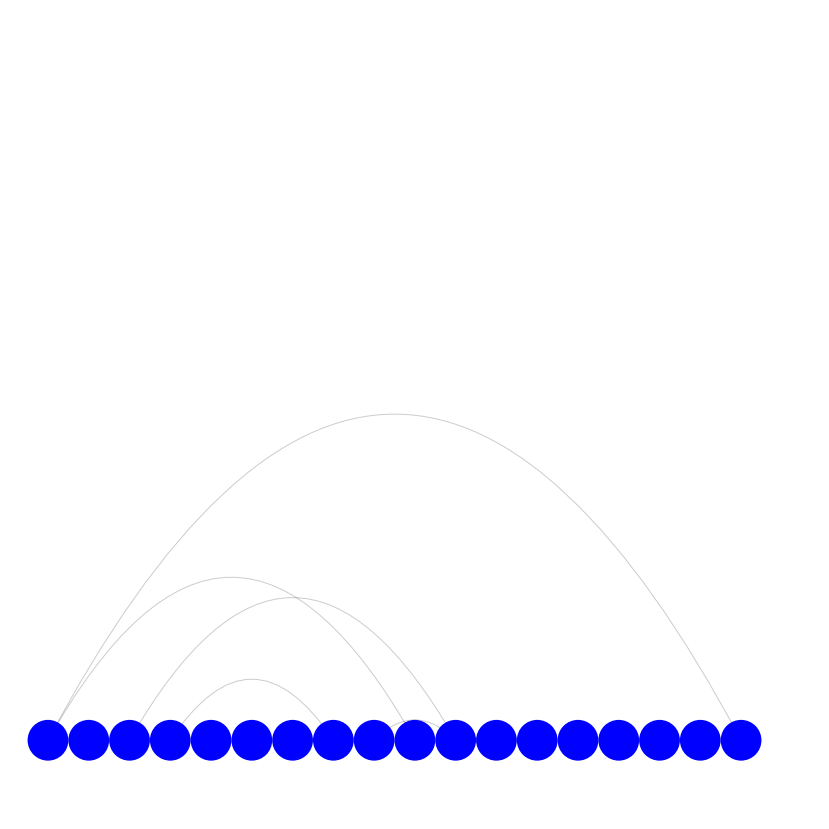

In [48]:
G_arc = nxv.ArcPlot(G, node_labels=True, figsize=(15,15))
G_arc.draw()

### G2 Topology (Figure 8) initialization

In [65]:
point_1 = np.asarray([0.875,0.,0.])
point_2 = np.asarray([-0.875,0.,0.])

unit_45 = np.asarray([np.sqrt((1.25**2)/2),0,np.sqrt((1.25**2)/2)])
unit_45_nx = np.asarray([-np.sqrt((1.25**2)/2),0,np.sqrt((1.25**2)/2)])
unit_45_nxnz = np.asarray([-np.sqrt((1.25**2)/2),0,-np.sqrt((1.25**2)/2)])
unit_45_nz = np.asarray([np.sqrt((1.25**2)/2),0,-np.sqrt((1.25**2)/2)])

add = [point_1]
for i in range(1,64):
    k = point_1 + i*unit_45
    add.append(k)
     
for i in range(1,64):
    j = add[-1] + unit_45_nx
    add.append(j)
    
    
add_x = []
for i in add[len(add)-1::-1]:
    i2 = [-i[0],i[1],i[2]]
    add_x.append(i2)

add2 = np.vstack((np.asarray(add), np.asarray(add[-1] + unit_45_nx), np.asarray(add_x)))
    
add_z = []
for i in add2[len(add2)-2:0:-1]:
    i2 = [i[0],i[1],-i[2]]
    add_z.append(i2)


add3 = np.vstack((add2, np.asarray(add_z)))
#add_x

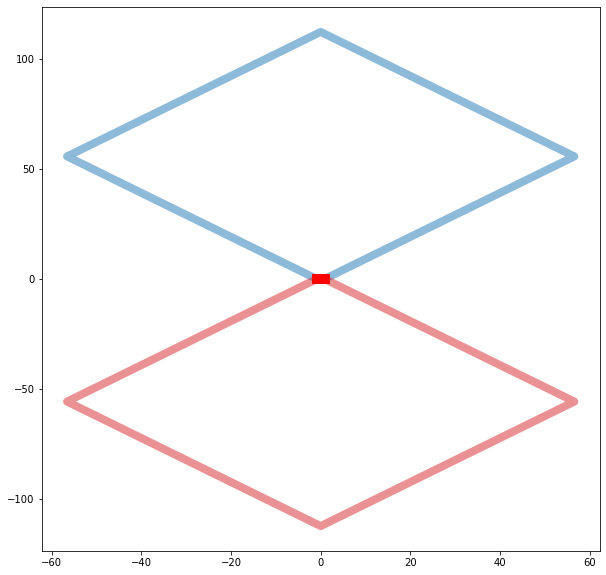

In [72]:
d1 = dist_calc(add3, plot=False)
NAB_matrix_g2 = np.zeros_like(d1)
NAB_matrix_g2[0][254] = 1

NAB_pairs_g2 = np.asarray(np.where(NAB_matrix_g2==1)).T
NAB_pairs_g2

#plotter123(g2, scat=True)
plt.figure(figsize=(10,10))
plt.plot(add3[:,0][0:int(len(add3)/2)], add3[:,2][0:int(len(add3)/2)], c = 'tab:blue', alpha=0.5, linewidth=8)
plt.plot(add3[:,0][int(len(add3)/2):], add3[:,2][int(len(add3)/2):], c='tab:red', alpha=0.5, linewidth=8)

for i in NAB_pairs_g2:
    plt.plot([add3[i[0]][0],add3[i[1]][0]], [add3[i[0]][2],add3[i[1]][2]], c='red', linewidth=10)

## Simulation/Iteration

In [584]:
def simulation(run_time, dt, temperature,  d3=False):
    
#_________________________INITIALIZAITON_________________________#
    
    "Define parameters here"
    
    diam = 1 #radius=diam/2
    #pen, pen_con, e are in units of k_b*t
    pen = 100000 #penalty for overlap and for moving past connection size
    #hard spheres; hard connection size
    pen_con = 100000 #LET"S MAKE IT DISALLOWED
    connect_size = 1.5 #=lambda = maximal connection size
    e = -1 #energetic benefit of depletion forces
    a = 1.75 #=diameter of depletion force square well (min distance between centers for depletion)
    k = 3000 #spring constant > units of k_bt???
    drag = 1 #this should be replaced by function of temperature and viscosity
    
    shaft_length= 16
    shaft_length_init = shaft_length
    conf_radius = 9 #radius of infinite cylinder containing polymer
    conf_radius_init = conf_radius
    
    #DYNAMIC TETHERING PARAMS:
    p_loss = 0.075
    cutoff_dist = 1.76
    p_form = .15
    hns_loading = 1
    
    
    "Defining tethers here"
    "TURNED OFF"
    NAB_matrix = NAB_matrix_1
    print(NAB_matrix[0][253])
  #  NAB_matrix_new = np.zeros_like(NAB_matrix)
    
    #initialize bead positions based such that potential energy falls under some threshold
    #maybe better to do this outside of simulation loop
    positions = init_positions
    num_beads = len(positions)
    
#    connections = make_circular_connections(positions)
    if d3 ==False:
        accel = np.zeros((num_beads, 2))
    if d3==True:
        accel = np.zeros((num_beads, 3))

    vel = accel
    
    #calculate repulsive energy to feed into U

    distances = dist_calc(positions)
    "TURNED OFF"
    #NAB_matrix =  np.zeros_like(distances)
    
    mon_accel, repulse_energy = repulse_accel(NAB_matrix, accel, num_beads, positions, distances, diam, temperature, k_b=1)
    "TURNED OFF"
    NAB_accel, NAB_en = nonadjacent_bonds(NAB_matrix, positions, distances, connect_size, diam, k, temperature, k_b=1)
#    NAB_en = 0
    
    accel, conf_energy = confinement_accel(mon_accel, conf_radius, num_beads, positions, diam, shaft_length, cap=True)
    
    #calculate initial energy
    U_prev = U_calc(NAB_en, repulse_energy, conf_energy, positions,distances, num_beads, diam, pen, pen_con, connect_size, e, a, k,
                    temperature, k_b=1, circ=True, conf=True)
    
    "Delete this to change back -- OR SIM WILL BREAK"
 #   accel = acc1
  #  vel = vel1
    
    #add in initial points to each list
    num_rej = 0
    U.append(U_prev)
    pos.append(positions)
    v.append(vel)
    ac.append(accel)
    rejc.append(num_rej)
    "TURNED OFF"
    NAB.append(NAB_matrix)

#_________________________ITERATION_________________________#
#now iterate through with Metropolis rejection
    for i in range(1, run_time):
        
        acceptance=False
        rc=0
        
        distances = dist_calc(positions)
        
        #calculate force field (non-random)
        #temp=False > means no random component > only drag force
        accel_springtemp = spring_accel(positions, distances, connect_size,diam, k, temperature=1, k_b=1)
        #can get rid of temperature scaling of spring_cons by setting temperature=1 > SHOULD ALSO change U_calc function if so
        
        "TURNED OFF"
        NAB_accel, NAB_en = nonadjacent_bonds(NAB_matrix, positions, distances, connect_size, diam, k, temperature, k_b=1)
        accel_bonds = accel_springtemp + NAB_accel

#        accel_bonds = accel_springtemp
        
        accel_rep, repulse_energy = repulse_accel(NAB_matrix, accel_bonds, num_beads, positions, distances, diam, temperature, k_b=1)
        accel_conf, conf_energy = confinement_accel(accel_rep, conf_radius, num_beads, positions, diam, shaft_length, cap=True)
        #accel_conf includes sum of all accel terms from force field
        
        #run and check against rejection rule
        while acceptance==False:
            #calculating drag vector in accel_temp function (really addition of 3 vectors)
            accel_new = accel_calc(accel_conf, vel, dt, temperature, drag, d3=d3, temp=True)
            positions_new = verlet_pos_calc(positions, vel, accel_new, dt)
            
            distances_n = dist_calc(positions)
            U_curr = U_calc(NAB_en, repulse_energy, conf_energy, positions_new, distances_n, num_beads, diam, pen, pen_con, connect_size, e, a, k, 
                            temperature, k_b=1, circ=True, conf=True)
            
        #    num_contacts, U_curr = bridging_energy(br_arr, distances_n, U_curr, a, br_energy, temperature, k_b=1)
            
            acceptance = metropolis_rule(U_prev, U_curr, temperature)
            rc+=1
        
        #FOR INCREASING LENGTH OVER TIME
        shaft_length = 16 + i*((4)/1e6)
 #       conf_radius = 11 - i*((5)/1e5)
 #       if i> int(1e5/2):
 #           k = 10
        
        "RELEASE ALL TETHERS AT 1,000 iterations in"
       # if i == int(2.5e5):
        #    NAB_matrix = NAB_matrix_new
        
        rc-=1
        #update values
        vel_new = vel_calc(accel_new, vel, dt)
        
        accel = accel_new
        vel = vel_new
        positions = positions_new
        U_prev = U_curr
        
        #save the simple information (1-d lists)
        U.append(U_prev)
        rejc.append(rc)
   #     num_bridge_con.append(num_contacts)
    
        
        #and every x MC sweeps (e.g. every 1000), save position, vel, accel
        if i % 1000 == 0: #if timestep mod 1000 = 0, then save data (i.e. save every 1000 timesteps) 
            pos.append(positions)
            v.append(vel)
            ac.append(accel)
            
        "TURNED OFF"
        if i % 10000 == 0:
            #DYNAMIC TETHERING
            curr_NABmatrix = NAB_matrix
            
            #new_NABmatrix = dynamic_tethering(curr_NABmatrix, positions, p_loss, p_form, cutoff_dist, hns_loading)
            max_tethers=80
            new_NABmatrix = dynamic_tethering_FEEDBACK(curr_NABmatrix, positions, p_loss, p_form, max_tethers, cutoff_dist, hns_loading)
            NAB_matrix = new_NABmatrix
            
            NAB.append(NAB_matrix) #and save record of tethering
        
    
    #And finally, saving the files
    path = os.getcwd()
    
    shaft_length_final = shaft_length
    conf_radius_final = conf_radius
    
    #NEED TO DEFINE CONF_RADIUS AND SHAFT_LENGTH NAMES (should probably automate this so I don't fuck it up)
    name = npy_namer(pen, connect_size, e, a, dt, run_time, 
              temperature, drag, k, conf_radius_init, conf_radius_final, shaft_length_init, shaft_length_final,
             p_loss, p_form, cutoff_dist, hns_loading, label)
    pp = path + '\\' + 'pos_' + name
    aa = path + '\\' + 'ac_' + name
    vv = path + '\\' + 'v_' + name
    uu = path + '\\' + 'u_' + name
    rjc = path + '\\' + 'rc_' + name
    "TURNED OFF"
    nab = path + '\\' + 'NAB_' + name
    np.save(pp, pos)
    np.save(aa, ac)
    np.save(vv, v)
    np.save(uu, U)
    np.save(rjc, rejc)
    np.save(nab, NAB)
        

In [358]:
def packing_ratio(num_beads, diam, shaft_length, conf_radius):
    "calculation of packing ratio (ratio of volumes between polymer and container)"
    
    v_sphere = (4/3)*((diam/2)**3)*np.pi
    v_spheres = num_beads*v_sphere
    
    v_container = (4/3)*(conf_radius**3)*np.pi + np.pi*shaft_length*conf_radius**2
    
    pr = v_spheres/v_container
    
    return pr

## Simulation Runs

Running simulations...

Currently saving to memory and then saving numpy arrays. Code in place to save directly to csv file (or other format), but seems buggy with no apparent fix.

In [589]:
#I/O seems to work when the current csv file being created is the only one in the directory

import time
s = time.time()

for i in range(1):
    
    label = 'tether_feedback_test_growing'
    U = []
    pos = []
    v = []
    ac = []
    rejc = []
    NAB = []
    #num_bridge_con = [] #for tracking bridging contacts ##NOT AUTOSAVED
    run_time = int(5e5) #RUN TIME = 100,000 (normaly 500,000)
    e=-1
    simulation(run_time, .0001, 300, d3=True) #changed dt from .0001
    
e = time.time()


0.0


# Analysis & Visualization

In [187]:
def cylinder_plot(shaft_length, conf_radius):
    
    z = np.arange(0,np.pi,.05)
    z2 = np.arange(np.pi, np.pi*2, .05)
    
    top_circle_x = []
    top_circle_y = []
    bot_circle_x = []
    bot_circle_y = []
    
    for i in z:
        top_circle_x.append(conf_radius*np.cos(i))
        top_circle_y.append(conf_radius*np.sin(i) + shaft_length/2)
        
    for i in z2:
        bot_circle_x.append(conf_radius*np.cos(i))
        bot_circle_y.append(conf_radius*np.sin(i) - shaft_length/2)
        
    connected_x = top_circle_x
    connected_y = top_circle_y
    
    for i in range(len(top_circle_x)):
        connected_x.append(bot_circle_x[i])
        connected_y.append(bot_circle_y[i])
        
    connected_x.append(top_circle_x[0])
    connected_y.append(top_circle_y[0])
    
    #plt.plot(connected_x, connected_y)

    return connected_x, connected_y    
        

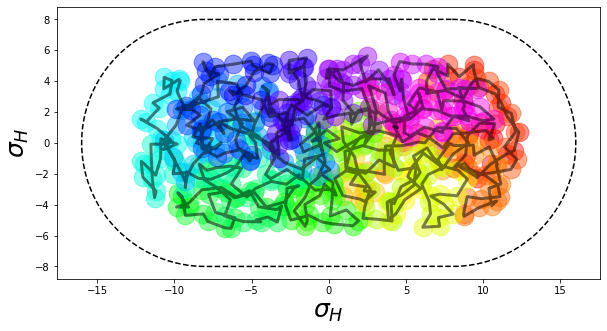

In [381]:
last = p_stat[0]
x = last[:,0]
z = last[:,2]
fig, ax = plt.subplots(figsize=(10,5))
n=len(x)
#colors = plt.cm.autumn(np.linspace(0,1,n))
colors = plt.cm.gist_rainbow(np.linspace(0,1,n))
for i in range(n):
    j = ax.scatter(z[i], x[i], alpha=0.45, s=350, color=colors[i])
    
#fig.colorbar(colors, ax=ax)
ax.plot(z, x, alpha=0.5, linewidth=3, color='black')
ax.plot([z[0], z[-1]], [x[0],x[-1]], alpha=0.5, linewidth=3, color='black')
#plt.scatter(x[0:int(len(x)/2)],z[0:int(len(x)/2)], alpha=0.5, s=100, c='tab:blue')
#plt.scatter(x[int(len(x)/2):],z[int(len(x)/2):], alpha=0.5, s=100, c='tab:red')
#plt.ylim(-20,20)
#plt.xlim(-8,8)

c_x, c_y = cylinder_plot(16, 8)
ax.plot(c_y, c_x, linestyle='dashed', c='black')
#c_x2, c_y2 = cylinder_plot(13, 7)
#ax.plot(c_y2, c_x2, linestyle='dashed', c='black')
ax.set_aspect('equal')
ax.set_ylabel("$\sigma_{H}$", size=25)
ax.set_xlabel("$\sigma_{H}$", size=25)
#plt.plot(zero_x, zero_z, c='red')
plt.savefig('phi17.png', dpi=300)


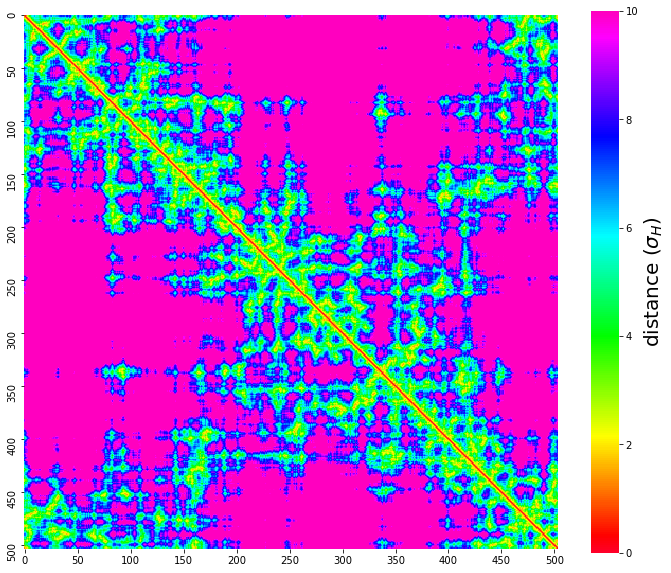

In [409]:
a = dist_calc(p_stat[0], plot=False)
fig,ax2 = plt.subplots(1,1, figsize=(10,10))
        #plt.figure(figsize=(10,10))
        #plt.gca().set_aspect("equal")      
fig.tight_layout()
        
ax2 = sns.heatmap(a, cmap='gist_rainbow', vmin=0,vmax=10,xticklabels = 50, yticklabels = 50, cbar_kws={'shrink':0.80, 'label': 'distance ($\sigma_{H}$)'})
ax2.figure.axes[-1].yaxis.label.set_size(20)
        #make heatmpa
        
ax2.set_aspect(1)
plt.savefig('cbart.png', dpi=300)

## Kymograph plot

MAKE THIS FOR E. COLI PLOTS (LIVE CELL) AND COMPARE THE DIFFERENCE...

In [306]:
def kymograph_plot(pos, num_bins, y_minmax):
    
    a123 = np.zeros((num_bins, len(pos)))
    
    bucket_size = y_minmax*2/num_bins
    
    for i, val in enumerate(pos):
        for k in val[:, 2]:
            if k<0:
                jj = int(k/bucket_size)
                j = num_bins/2 - jj
                a123[int(j)][i] += 1
            if k>0:
                jj = int(k/bucket_size)
                j = num_bins/2 - 1 - jj
                a123[int(j)][i] += 1
                
            #INCLUDING BOTTOM AND TOP OF MONOMER
            top = k+0.75
            bot = k-0.75
            if top<0:
                jj = int(top/bucket_size)
                j = num_bins/2 - jj
                a123[int(j)][i] += 1
            if top>0:
                jj = int(top/bucket_size)
                j = num_bins/2 - 1 - jj
                a123[int(j)][i] += 1
                
            if bot<0:
                jj = int(bot/bucket_size)
                j = num_bins/2 - jj
                a123[int(j)][i] += 1
            if bot>0:
                jj = int(bot/bucket_size)
                j = num_bins/2 - 1 - jj
                a123[int(j)][i] += 1
            
                
    plt.figure(figsize=(20,10))
    sns.heatmap(a123, vmin=0, vmax=80)
    
    return a123

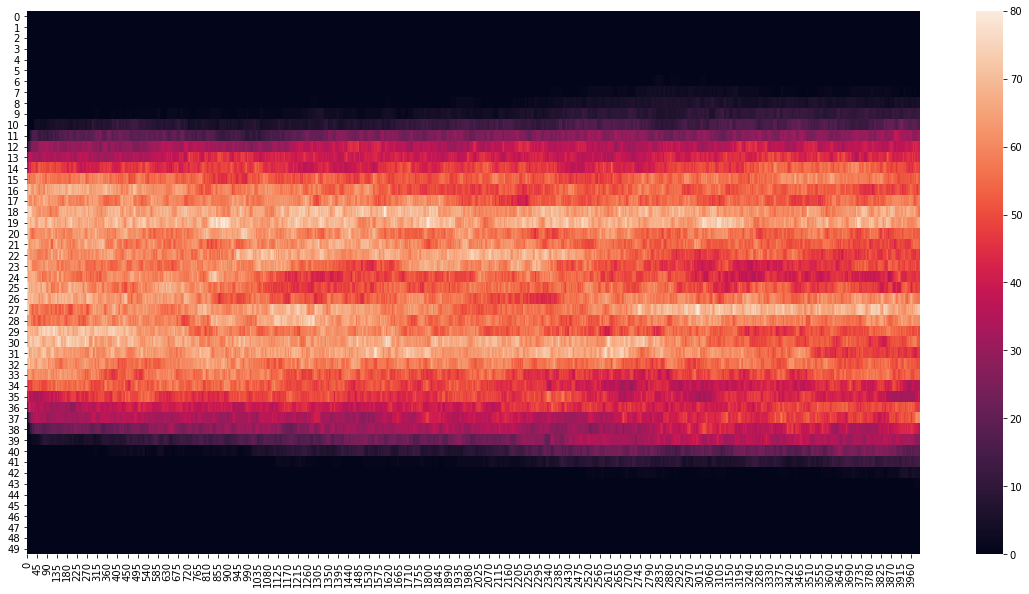

In [846]:
num_bins = 50
y_minmax = 24
kymograph_plot(p_notethers_grow2, num_bins, y_minmax)

In [630]:
def alt_kymograph_plot(pos, y_minmax):
           
    plt.figure(figsize=(20,10))
    plt.ylim(-y_minmax, y_minmax)
    
    abc = np.zeros((len(pos[0]), len(pos)))
    
    for i, val in enumerate(pos):
        for k, v2 in enumerate(val[:, 2]):
            abc[k][i] = v2
            
    for i in range(len(pos[0])):
        plt.plot(abc[i,:], c = 'tab:blue', linewidth=2, alpha = 0.25)
    


(0.0, 4000.0)

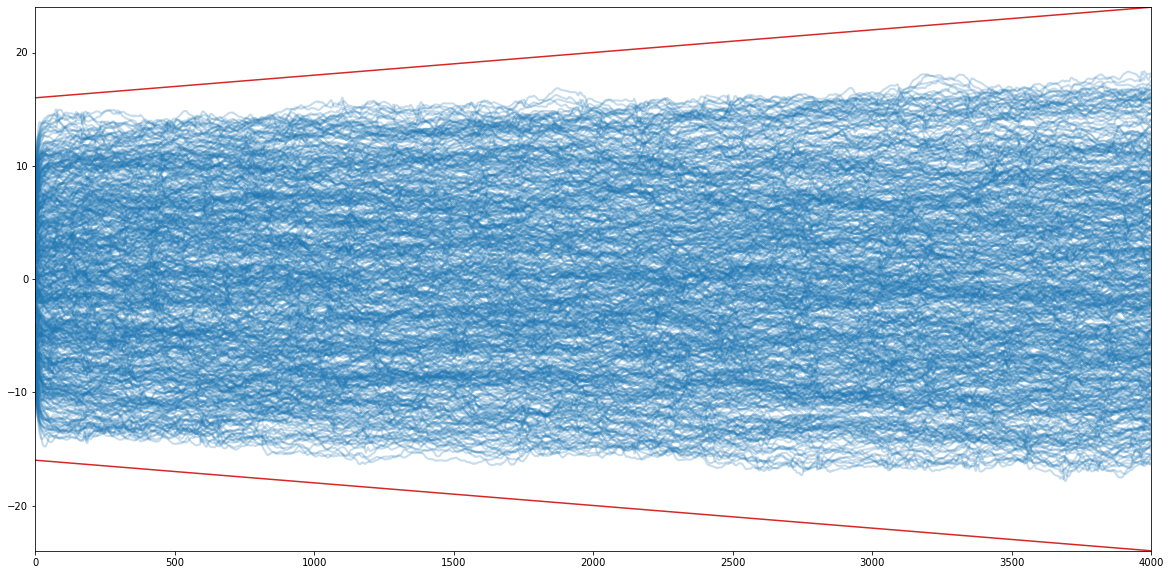

In [634]:
alt_kymograph_plot(ptHIGH_g, y_minmax)
plt.plot([0,4000],[-16,-24], c='tab:red')
plt.plot([0,4000],[16,24], c='tab:red')
plt.xlim(0,4000)

#COULD ALSO PLOT HIGHEST AND LOWEST POINT WITH A SOLID LINE     

## Distance histogram

In [628]:
p_notethers_grow1_1 = np.load('pos_notethers_grow1_lam1.5_e-1_a1.75_dt0.0001_T300_drag1_k3000_cradi9_cradf9_sleni16_slenf23.999996_ploss0.25_pform0.075_cutoff1.76_hnsloading1_2021-01-14 18_40_45.003616.npy')
p_notethers_grow1_2 = np.load('pos_notethers_grow1_PART2_lam1.5_e-1_a1.75_dt0.0001_T300_drag1_k3000_cradi9_cradf9_sleni24_slenf31.999996_ploss0.25_pform0.075_cutoff1.76_hnsloading1_2021-01-15 22_46_01.620884.npy')

pg2 = np.load('pos_notethers_grow1_lam1.5_e-1_a1.75_dt0.0001_T300_drag1_k3000_cradi9_cradf9_sleni16_slenf31.999996_ploss0.25_pform0.25_cutoff1.76_hnsloading1_2021-01-21 21_02_23.278692.npy')

In [627]:
#making a histogram of distances
def dist_hist(pos, time):
    distances = dist_calc(pos[time])

    dist_hist_1 = []
    for i in range(len(distances)):
        for k in range(i+1,len(distances)):
            bb = distances[i][k]
            dist_hist_1.append(bb)

    return dist_hist_1

Text(0.5, 1.0, '')

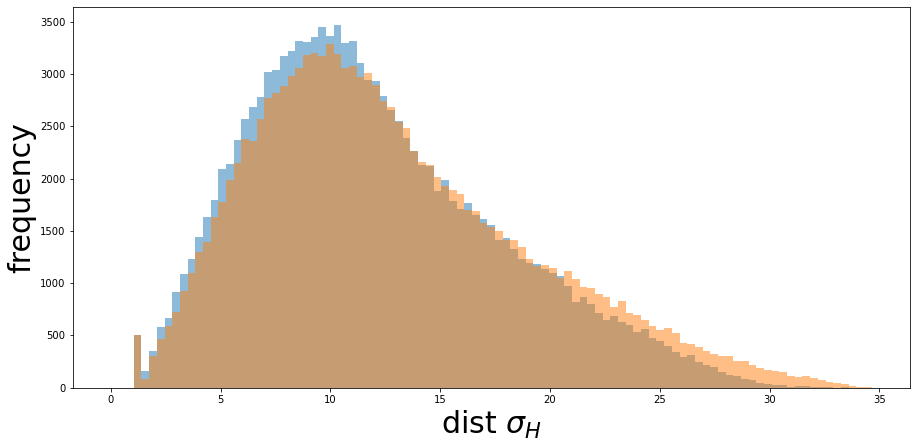

In [631]:
num_bins = 100
dist_cutoff = 35
bins_list = np.arange(0,dist_cutoff, dist_cutoff/num_bins)

time_1=-1
time_2 = 50
dh1 = dist_hist(pg2, time_1)
dh2 = dist_hist(ptHIGH_g, time_1)
plt.figure(figsize=(15,7))
plt.hist(dh1, bins=bins_list, alpha=0.5)
plt.hist(dh2, bins=bins_list, alpha=0.5)

plt.xlabel('dist $\sigma_{H}$', size=30)
plt.ylabel('frequency', size=30)
plt.title('')

kolmogorov-smirnov testig for difference between histograms:
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test


In [630]:
from scipy.stats import ks_2samp

ks_2samp(dh1, dh2)

KstestResult(statistic=0.044218814099529824, pvalue=4.012649628278569e-108)

## Energy Plot (broken up by type)

In [524]:
def U_calc_PLOT(repulse_energy, positions,  e, k_b=1, circ=True, conf=True):
    
#    positions = positions.reshape((num_beads, 2))  #FOR OPTIMIZATION > 1d/flattened array
    dist = dist_calc(positions)
    num_beads = len(positions)
    diam = 1
    #pen, pen_con, e are in units of k_b*t
    pen = 100000 #penalty for overlap and for moving past connection size
    #hard spheres; hard connection size
    pen_con = 100000 #LET"S MAKE IT DISALLOWED
    connect_size = 1.5 #=lambda = maximal connection size
    a = 1.75 #=diameter of depletion force square well (min distance between centers for depletion)
    k = 3000 #spring constant > units of k_bt???
    drag = 1
    temperature = 300
    
    #first calculate distance matrix
    #dist = dist_calc(positions)
   # dist = distances
    u_tri = np.triu(dist)

    # identity upper triangular matrix with diagonal entries=0 
    identity_ut = np.triu(np.ones((num_beads,num_beads)))
    np.fill_diagonal(identity_ut, 0)
    
##_______________________________MONOMER REPULSION_______________________________##
    
    #take u_tri and use it to calculate U_repulsive and U_attractive
    u_rep = u_tri - ((diam)*identity_ut)
    #NEED TO ADD e to pen otherwise depletion forces act during bead overlap
    u_repulsive = np.sum(np.where(u_rep < 0, 1, 0))*(pen-e)*k_b*temperature + repulse_energy
    
##_______________________________DEPLETION_______________________________##
    
    #getting rid of contribution of adjacent monomers > no depletion force
    diag_1 = np.diag(u_tri, 1)
    diag_2 = np.diag(u_tri, (num_beads-1))
    mat_diag_1 = np.diag(diag_1, 1) + np.diag(diag_2,(num_beads-1))
    identity_ut_2 = identity_ut - np.diag(np.ones(num_beads-1),1) - np.diag([1], (num_beads-1))
    
    u_att = (u_tri-mat_diag_1) - (a*identity_ut_2)
    u_attractive = np.sum(np.where(u_att < 0, 1, 0))*e*k_b*temperature #e < 0
    
##_______________________________CONNECTIONS_______________________________##
    #now calculate u_connections
    #calculating a flattened array for each of the connection distances
    if circ==True:
        i = np.diag(u_tri, k=1)
        ii = np.diag(u_tri, k=num_beads-1)
        flat_c_length = np.concatenate((i, ii))

        u_con = flat_c_length - connect_size*np.ones(num_beads)
        u_connections = np.sum(np.where(u_con > 0, 1, 0))*pen_con*k_b*temperature 
    
    if circ==False:
        i = np.diag(u_tri, k=1)
        flat_c_length = i

        u_con = flat_c_length - connect_size*np.ones(num_beads-1)
        u_connections = np.sum(np.where(u_con > 0, 1, 0))*pen_con*k_b*temperature 
    
    
##_______________________________ELASTICITY OF CONNECTIONS (new)___________________________## 

#adding in elastic omponent to connections so there's energy associated with 
#assuming Circ=True; can change later
    
    #from above, take the distance between each of the connections
    #say that the natural connection length (u=0) is equal to 1/2 max connect_size (lam)
    r_0 = diam + (connect_size-diam)/2
    dr_max = (connect_size-diam)/2
    
    d_x = (flat_c_length - (r_0)*np.ones(num_beads)) #(r-r_0)
    u_elastic = np.log(np.ones(num_beads) - (d_x/dr_max)**2) #ln(1- (∆x/∆r_max)^2)
    
    #switched to FENE
    spring_cons = k #(units of kbt)
    u_con_spring = -0.5*(spring_cons)*((dr_max)**2)*np.sum(u_elastic) #*k_b*temperature
    
    #not sure if it's right to scale the spring constant here and not scale it in the calculation of force vector
    #could just add it into the force vector


##_______________________________CONFINEMENT_______________________________##
    other_accel = np.zeros_like(positions)
    NAB_matrix = np.zeros_like(dist_calc(positions))
    
 #   otheraccel, repulse_energy = repulse_accel(NAB_matrix, other_accel, num_beads, positions, distances, diam, temperature, k_b=1)
    
    return u_attractive/temperature,  u_con_spring/temperature
    
#, u_con_spring, u_repulsive, u_attractive, u_connections, u_elastic

#COULD be better to return all of these, so that I know which terms are dominating the potential

In [525]:
NAB_en = 0
repulse_energy = 0
e = -1

ud = []
us = []
for t in range(len(pstat0)):
    positions = pstat0[t]

#    NAB_matrix = np.zeros_like(dist_calc(positions))

    u_depletion, u_con_spring  = U_calc_PLOT(repulse_energy, positions,  e, k_b=1, circ=True, conf=True)
    ud.append(u_depletion)
    us.append(u_con_spring)

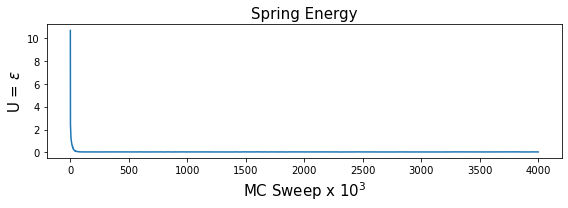

In [594]:

plt.figure(figsize=(8,3))
plt.plot(us[0:])
plt.title('Spring Energy', size=15)
plt.ylabel('U = $\epsilon$', size=15)
plt.xlabel('MC Sweep x $10^{3}$', size=15)
plt.tight_layout()
plt.savefig('springenergy_stat.png', dpi=300)


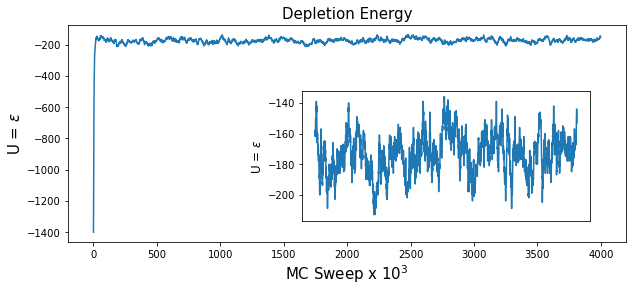

In [582]:
fig, ax1 = plt.subplots(figsize=(10,4))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.45, 0.2, 0.4, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.set_title('Depletion Energy', size=15)
ax1.set_ylabel('U = $\epsilon$', size=15)
ax2.set_ylabel('U = $\epsilon$', size=12)
ax1.set_xlabel('MC Sweep x $10^{3}$', size=15)
ax1.plot(ud)
ax2.plot(ud[1000:])
ax2.set_xticks([])


plt.savefig('depletionforces_stat.png', dpi=300)

In [266]:
def accel_reader(accel, plot=True):
    
    sd = []
    avg = []
    
    for i, val in enumerate(accel):
        s = np.std(val)
        a = np.average(val)
        sd.append(s)
        avg.append(a)
    
    avg_a = np.asarray(avg)
    sd_a = np.asarray(sd)
    
    if plot==True:
        
        plt.figure(figsize = (10,5))
        t = np.arange(0, len(accel),1)
        plt.plot(t, avg_a, label = 'average')
        #plt.plot(t, sd_a, label = 'variance')
    
        plt.fill_between(t, avg_a-sd_a, avg_a+sd_a,
                 color='red', alpha=0.2, label='std_dev')

        plt.legend()
    return avg_a, sd_a
    
    
        

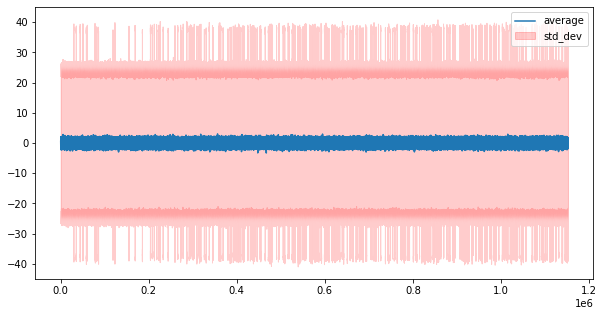

In [25]:
avg, sd = accel_reader(merged_ac, plot=True)
#runaway accel at 12000 > need smaller time steps??

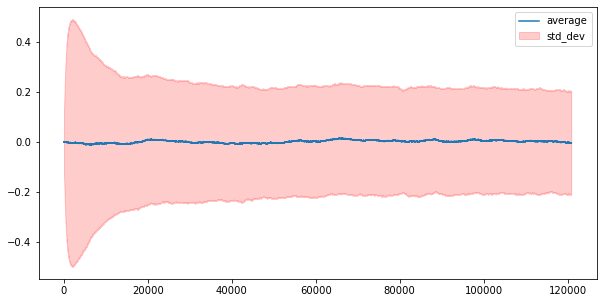

In [269]:
#same function works for velocity

avg_vel, sd_vel = accel_reader(v, plot=True)

In [ ]:
#if range=True, then it will compile all of the values that you've put in for accel_t
#and output a histogram
def hist_maker(accel_t, num_bins, Range=True, plot=True):
    
    if Range==False:
        zero = np.zeros(np.shape(accel_t))
        sizes = np.linalg.norm(zero-accel_t, axis=1)
    
    elif Range==True:
        zero = np.zeros(np.shape(accel_t[0]))
        sizes = []
        for i, val in enumerate(accel_t):
            s = np.linalg.norm(zero-val, axis=1)
            for k in s:
                sizes.append(k)
    
    if plot==True:
        plt.hist(sizes, bins=num_bins)
    
    return sizes

## Length curve and fourier analysis

length conversion:
2 uM = 15+12 = 27 units
1 uM = 13.5 units

In [221]:
def regression(x, y, degree):
    #x = np.linspace(0,1000,1000)
    a = np.polyfit(x, y, degree, full=False)
    ylin = []

    for i in x:
        
        y_lin = 0
        
        for k in range(degree+1):
            y_lin+= (i**(degree-k))*a[k]
        
        
        ylin.append(y_lin)
        
    
    r = np.corrcoef(y, ylin)[0][1]
    rsq = r**2
    return ylin, a, rsq

In [222]:
def detrend(y, degree):
    
    
    x = np.linspace(0,len(y),len(y))
    ylin, a, rsq = regression(x, y, degree)
    
    detrended = [y[i] - ylin[i] for i in range(len(ylin))]
    
    return detrended, rsq, ylin

In [220]:
#scaling = 1/13.5
def len_curve_sim(p1, scaling):
    "only does it for a single curve, not for bulk group of positions"
    
    lens = []
    for i in p1:
        len1 = max(i[:,2]) - min(i[:,2])
        lens.append(len1*scaling) #converts to microns

    #now detrending
    detrended, rsq1, ylin = detrend(lens, 5) #polynomial degree 5 detrending
   
    
    return lens, detrended, ylin

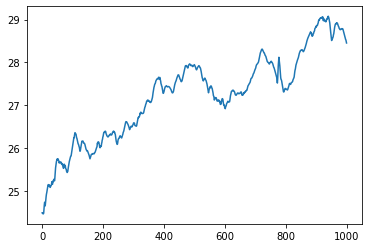

In [237]:
lens, detrended, ylin = len_curve_sim(pos, 1)
plt.plot(lens)

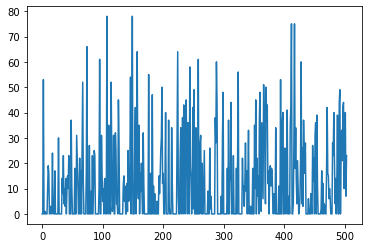

In [228]:
plt.plot(sum(sum(NAB)))

In [140]:
scaling = 1/13.5
lens1, detrended1, ylin1 = len_curve_sim(g1_0, scaling)

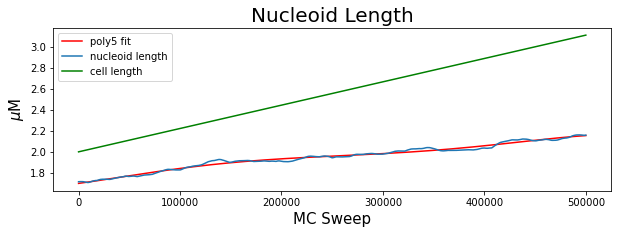

In [272]:
plt.figure(figsize=(10,3))

plt.plot(ylin1, color='red', label='poly5 fit')
plt.plot(lens1, label='nucleoid length')
x = np.arange(0,len(lens1))
y = [(27 + i*3e-5)/13.5 for i in x]
plt.plot(x, y, label = 'cell length', color='green')
plt.title('Nucleoid Length', size=20)
plt.ylabel('$\mu$M', size=15)
plt.xlabel('MC Sweep', size=15)
plt.legend()

Text(0.5, 0, 'MC Sweep')

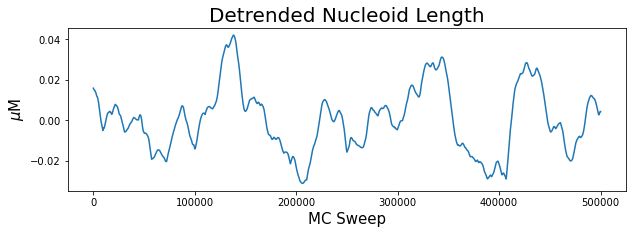

In [132]:
plt.figure(figsize=(10,3))
plt.plot(detrended1)
plt.title('Detrended Nucleoid Length', size=20)
plt.ylabel('$\mu$M', size=15)
plt.xlabel('MC Sweep', size=15)

## Fourier analysis misc.

In [420]:
def fourier(signal, timestep, plot=False):
    "timestep gives distance between samples in minutes (35/60)"
    
    #take signal and zero-pad it such that all of the signals are 10,000 in length
    #signal = np.hstack((signal,np.zeros(10000-len(signal)))) 
    
    #NO ZERO PADDING HERE

    ft = np.fft.fft(signal)

    #this gives the frequencies associated with the coefficients
    n = signal.size

    freq = np.fft.fftfreq(n, d=timestep)
    
    #only returning the positive component(?)
    f_pos = freq[0:int(len(freq)/2)+1]
    f_pos[-1] = abs(f_pos[-1])
    
    ft_pos = ft[0:int(len(freq)/2)+1]
    
    
    return ft_pos, f_pos #be mindful that I'm only returning half the output

In [421]:
def get_maxfreq(ft, freq, len_sample, plot=False):
    #len_sample = sample length without zero padding
    
    a_max = np.argmax(abs(ft))
    freq_max = freq[a_max]
    per_max = 1/freq_max
    
    amplitude = 2 / len_sample * np.abs(ft)
    phase = np.angle(ft) + np.pi/2 #fitting it to a sin curve
    
    amp_max = amplitude[a_max]
    ph_max = phase[a_max]
    
    if plot==True:
        fig, axs = plt.subplots(2, figsize=(10,6))
        fig.suptitle('dominant signal: ' + str(np.round(amp_max,3)) + ' sin(2$\pi$x*' + str(np.round(freq_max,7)) +  ' + ' + str(np.round(ph_max,3)) + ')', size=15)
        axs[0].plot(freq, amplitude)
        axs[0].plot(freq[a_max]*np.ones(2), [0,amplitude[a_max]], linestyle='dashed', color='red')
        axs[1].plot(freq, phase)
        axs[1].plot(freq[a_max]*np.ones(2), [-np.pi/2,(3/2)*np.pi], linestyle='dashed', color='red')
        
        axs[0].set_ylabel('amplitude ($\mu$M)', size=15)
        axs[1].set_ylabel('phase', size=15)
        axs[1].set_xlabel('frequency (MC Sweep$^{-1}$)', size=15)
        
        axs[1].set_xlim(0,.0002)
        axs[0].set_xlim(0,.0002)
        
    return freq_max, amp_max, ph_max, per_max

In [422]:
def fourier_bulk(detrended, timestep, descriptor):
    'return rsq and dominant freq, per, phase, and amplitude of e/c'
    #descriptor = string description of dataset
    
    freqs = []
    amps = []
    phases = []
    periods = []
    
    rsq = []
    cycle_len = []
    
    for i in detrended:
        signal = i

        ft, freq = fourier(signal, timestep, plot=False)
        
        len_sample = len(i)
        freq_max, amp_max, ph_max, per_max = get_maxfreq(ft, freq, len_sample, plot=False)
    
        freqs.append(freq_max)
        amps.append(amp_max)
        phases.append(ph_max)
        periods.append(per_max)
        
        x = np.arange(0,len(i))*(timestep)
        
        y_pred = amp_max*np.sin(2*np.pi*freq_max*x + ph_max)
        
        correlation_matrix = np.corrcoef(i, y_pred)
        correlation_xy = correlation_matrix[0,1]
        r_squared = correlation_xy**2
        rsq.append(r_squared)
        
        cl = len(i)*timestep
        cycle_len.append(cl)
        
    d = {'frequency':freqs, 'amplitude':amps, 'phase':phases, 'period': periods, 'rsq':rsq, 'cycle_len':cycle_len, 'description': [descriptor]*len(freqs)}    
    df = pd.DataFrame(data=d)
    
    return df

In [160]:
scaling = 1/13.5
lens1, detrended1, ylin1 = len_curve_sim(g1_0, scaling)
lens2, detrended2, ylin2 = len_curve_sim(g1_2, scaling)
lens3, detrended3, ylin3 = len_curve_sim(g1_3, scaling)
lens4, detrended4, ylin4 = len_curve_sim(g1_4, scaling)

In [193]:
#LETS HAVE 2 um
timestep=1
signal1 = [np.asarray(detrended1), np.asarray(detrended2), np.asarray(detrended3), np.asarray(detrended4)]

df = fourier_bulk(signal1, timestep, 'Growing ($e = -1k_{b}T$)')



Text(0, 0.5, '$\\mu$M')

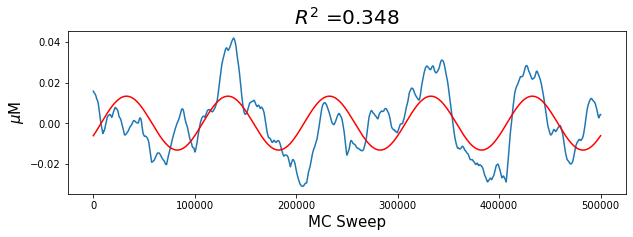

In [177]:
#LETS HAVE 2 um
timestep=1
signal1 = [np.asarray(detrended1), np.asarray(detrended2), np.asarray(detrended3), np.asarray(detrended4)]

df = fourier_bulk(signal1, timestep, 'Growing ($e = -1k_{b}T$)')

cell_num = 0

amp_max = df['amplitude'][cell_num]
ph_max = df['phase'][cell_num]
freq_max = df['frequency'][cell_num]

x = np.arange(0,len(signal1[cell_num]))
y_pred = amp_max*np.sin(2*np.pi*freq_max*x + ph_max)


plt.figure(figsize=(10,3))
plt.title('$R^{2}$ ='+ str(np.round(df['rsq'][cell_num], 3)), size=20)
plt.plot(x,signal1[cell_num])
plt.plot(x, y_pred, c="red")
plt.xlabel('MC Sweep', size=15)
plt.ylabel('$\mu$M',size=15)

## Mathematica Viz

Somewhat clunky code for converting to usable syntax for polymer visualization in 3D in Mathematica.

In [143]:
#To change print options back to normal
np.set_printoptions(precision=None, suppress=None)

In [448]:
np.set_printoptions(precision=None, suppress=True) #none = sceitnfic notation

def stringify(positions, time):
    'turn array of numbers into a string for use in mathematica viz'
    
    bb = []
    for i in positions[time]:
        kk = np.round(i,4)
        bb.append(kk)

    #circularize
    first = np.round(positions[time][0],4)
    bb.append(first)    
    
    str1 = str(bb)
    str2 = str1.replace('[','{')
    str3 = str2.replace(']','}')
    str4 = str3.replace('(', '')
    str5 = str4.replace('array', '')
    str6 = str5.replace(')','')
    
    return str6
    

In [765]:
def stringify_NAB(NAB_pairs, positions, time):
    'turn array of numbers into a string for use in mathematica viz'
    
    bb = np.zeros((len(NAB_pairs), 2,3))
    for counter, i in enumerate(NAB_pairs):
        first = positions[time][i[0]]
        sec = positions[time][i[1]] #SWITCH BACK TO TIME*10 FOR ALL BUT LAST
        bb[counter][0] = np.round(first,4)
        bb[counter][1] = np.round(sec,4)
    
    poop = []
    for i in range(len(bb)):
        str1 = str(list(bb[i]))
        str2 = str1.replace('[','{')
        str3 = str2.replace(']','}')
        str4 = 'arr' + str(i+2) + '='
        str5 = str3.replace('array', '')
        str6 = str5.replace(')','')
        str7 = str6.replace('(','')
        str8 = str4 + str7 + ';'
        poop.append(str8)
        
    result = ''.join(poop[:])
    return result


In [766]:
def stringify_NAB_2(NAB_pairs):
    poop = []
    poop2 = []
    for i in range(len(NAB_pairs)):
        aa = 'l' + str(i) + '=Graphics3D[{ colortethers, CapForm["Round"], Specularity[White, 5], Tube[arr' + str(i+2) + ', 0.75]}];'
        poop.append(aa)
        poop2.append('l' + str(i) + ',')

    result = ''.join(poop[:])
    result2 = ''.join(poop2[:])
    
    return result, result2

In [450]:
def macrodomains_str(num_domains, positions, time):
    
    ind = len(positions[time])//num_domains
    
    poop = []
    for i in range(num_domains):
        bb = []
        for k in positions[time][i*ind:i*ind+ind+1]:
            kk = np.round(k,4)
            bb.append(kk)

        #circularize
        if i==num_domains-1:
            first = np.round(positions[time][0],4)
            bb.append(first)    

        str1 = str(bb)
        str2 = str1.replace('[','{')
        str3 = str2.replace(']','}')
        str4 = str3.replace('(', '')
        str5 = str4.replace('array', '')
        str6 = str5.replace(')','')
        
        poop.append('macroarr' + str(i+1) + '=' + str6 + ';')
        #print('macroarr' + str(i+1) + '=' + str6 + ';')
    
    result = ''.join(poop[:])
    return result
        
    

## Mean Square Displacement (MSD)

In [949]:
def autocorrFFT(x):
    "https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft"
    N=len(x)
    F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   #now we have the autocorrelation in convention B
    n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A

In [950]:
def msd_fft(r):
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return S1-2*S2

In [955]:
def msd_calc(pg2, scaling, plot=True):
    p0_scaled = np.asarray(pg2)*(scaling)

    msd_0 = []

    for i in range(len(p0_scaled[0])): #iterate through for each monomer
        m0 = msd_fft(p0_scaled[:,i])

        msd_0.append(m0)
        
    
    if plot==True:
        #log version
        plt.figure(figsize=(20,6))
        plt.ylabel('MSD ($\sigma_{H}^{2}$)', size=15)
        plt.xlabel('MC Sweep', size=15)
        plt.title('Mean Squared Displacement of Expanding Cell', size=17)

        x = np.arange(0,len(pg2)*1e3,1e3)

        for i in msd_0:
            plt.loglog(x,i, color='b', alpha=0.1)

        #plt.loglog(x,y, linewidth=5, color='red')    

        plt.ylim(1e-4,100)
        plt.xlim(1e3,4e6)
#    plt.savefig('msdloglog', dpi=350)  
    
    return msd_0;
#return msd for each monomer

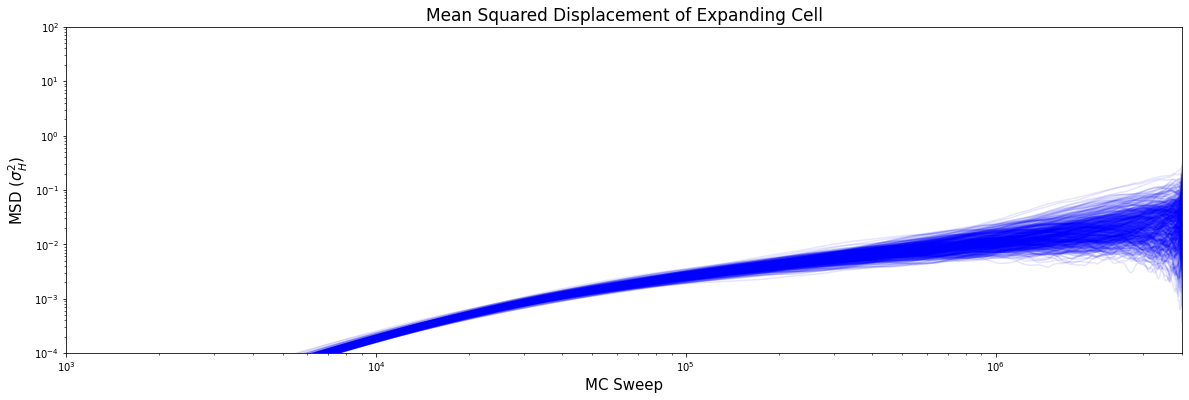

In [1000]:
scaling=1/16
pg2=p_notethers_grow1[0:]
msd_0 = msd_calc(pg2, scaling, plot=True)

## power law scaling function function that actually works

In [958]:
def monomer_merge(msd, skip_interval, x):
    "takes in the msd list and turns it into a 2 1-d lists that can be interpreted for power law fitting"

    x_merged = []
    msd_merged = []
    
    for i in msd:
        for k in i:
            msd_merged.append(k)

    for i in range(len(msd)):
        for k in x:
            x_merged.append(k)
            
    return x_merged, msd_merged

In [976]:
msd=msd_0
skip_interval=1
x = np.arange(0,len(pg2)*1e3,1e3)

x_merged, msd_merged = monomer_merge(msd, skip_interval, x)

In [960]:
# Import curve fitting package from scipy
from scipy.optimize import curve_fit

# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

In [961]:
def powerlaw_fit(x_merged, msd_merged, Print=False):
    pars, cov = curve_fit(f=power_law, xdata=x_merged, ydata=msd_merged, p0=[0, 0], bounds=(-np.inf, np.inf))

    stdevs = np.sqrt(np.diag(cov))

    if Print==True:
        
        print('y = ax^{b}:' + '\n' + 'a = ' + str(pars[0]) + '\n' + 'b = ' + str(pars[1]))
    
    return pars, cov, stdevs

In [962]:
pars, cov, stdevs = powerlaw_fit(x_merged, msd_merged)

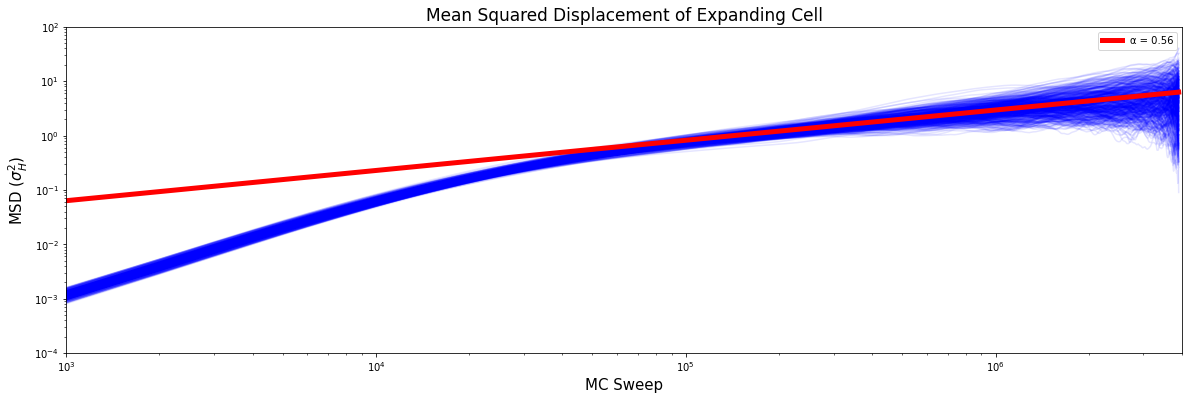

In [964]:
plt.figure(figsize=(20,6))
plt.ylabel('MSD ($\sigma_{H}^{2}$)', size=15)
plt.xlabel('MC Sweep', size=15)
plt.title('Mean Squared Displacement of Expanding Cell', size=17)

x = np.arange(0,len(pg2)*1e3,1e3)

for i in msd_0:
    plt.loglog(x,i, color='b', alpha=0.1)

        #plt.loglog(x,y, linewidth=5, color='red')    
plt.ylim(1e-4,100)
plt.xlim(1e3,4e6)

#x_2 = np.arange(0,4e3,1)

y = power_law(x, pars[0],pars[1])
plt.loglog(x,y, label='α = ' + str(np.round(pars[1],2)), c='red', linewidth=5)
plt.legend()


In [977]:
#now making a function that splits things up and calculates power law for each section
def powerlaw_interval(msd, msd_merged, x_merged, interval):
    
    #interval should cleanly divide length of sample (e.g. 200 for sample of len 4000)
    #ALTERNATIVELY, interval can be 1-d array of **starting** points
    "MUST INCLUDE END_POINT IN INTERVAL ARRAY"
    
    num_beads = len(msd)
    #each time interval is actually 
    len_sample = len(msd[0])
    
    fit_saver = []
    cov_std_saver = []
    
    if type(interval)==int:
    
        for k in range(0, len_sample, interval):
            md = msd_merged[(num_beads*k):(num_beads*(k+interval))]
            x1 = x_merged[(num_beads*k):(num_beads*(k+interval))]
            pars, cov, stdevs = powerlaw_fit(x1, md);
            fit_saver.append(pars)
    
    else:
        
        for k in range(0, len(interval)-1):
            
            md = msd_merged[(num_beads*interval[k]):(num_beads*(interval[k+1]))]
            print(len(md))
            x1 = x_merged[(num_beads*interval[k]):(num_beads*(interval[k+1]))]
            pars, cov, stdevs = powerlaw_fit(x1, md);
            fit_saver.append(pars)
            cov_std_saver.append([cov, stdevs])

    return fit_saver, cov_std_saver

## power law fitting
https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

$$y = ax^{b}$$

A ends up being diffusion coefficient and b is equal to the power law scaling?

In [67]:
#checking situation for stationary cells...
skipping = 499
md_stat, msd_list_stat = msd(p0_0, (1/13.5), skipping, plot=False)

In [683]:
skipping = 1
scaling = 1
dataset = p_unconf
md_stat, msd_list = msd(dataset, scaling, skipping, plot=False)

x = np.arange(0, len(dataset)+1, 1)
x_merged, msd_merged = monomer_merge(msd_list, skipping, x)

pars, cov, stdevs = powerlaw_fit(x_merged, msd_merged)
p = []
p.append(pars)

y = ax^{b}:
a = 0.8366429362160057
b = 0.36905047737945645


In [672]:
# Import curve fitting package from scipy
from scipy.optimize import curve_fit

# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)


In [673]:
def data_reducer(msd_list, skip_interval, restrict=None):
    'restrict defines min and max of taken data'
    reduced_msd = []

    if restrict==None:
        for i in msd_list:
            reduced_msd.append(i[::skip_interval])
    
    else:
        for i in msd_list:
            reduced_msd.append(i[restrict[0]:restrict[1]:skip_interval])
        
    return reduced_msd

In [674]:
def monomer_merge(reduced_msd, skip_interval, x):
    "takes in the reduced msd list and turns it into a 2 1-d lists that can be interpreted for power law fitting"

    x_merged = []
    msd_merged = []
    
    for i in reduced_msd:
        for k in i:
            msd_merged.append(k)

    for i in range(len(reduced_msd)):
        for k in x:
            x_merged.append(k)
            
    return x_merged, msd_merged

In [675]:
def powerlaw_fit(x_merged, msd_merged):
    pars, cov = curve_fit(f=power_law, xdata=x_merged, ydata=msd_merged, p0=[0, 0], bounds=(-np.inf, np.inf))

    stdevs = np.sqrt(np.diag(cov))

    print('y = ax^{b}:' + '\n' + 'a = ' + str(pars[0]) + '\n' + 'b = ' + str(pars[1]))
    
    return pars, cov, stdevs

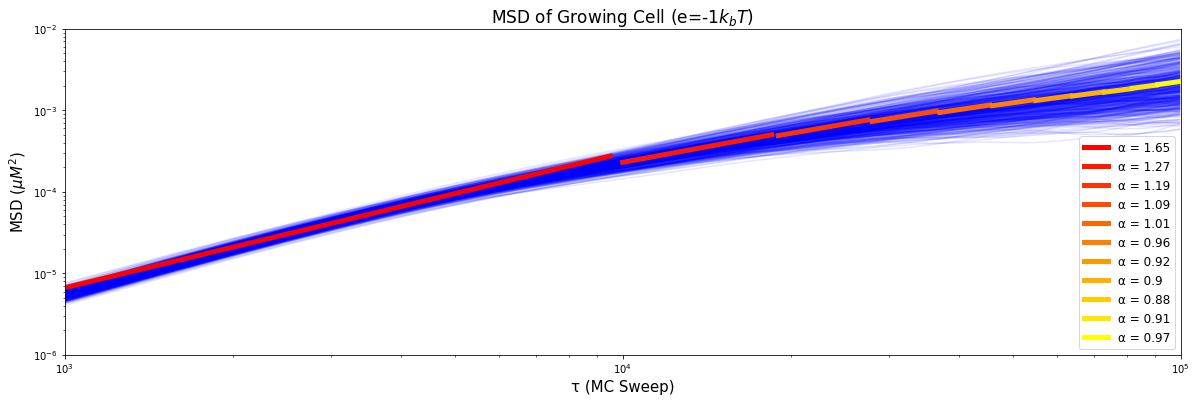

In [263]:
#log version
plt.figure(figsize=(20,6))
plt.ylabel('MSD ($\mu M^{2}$)', size=15)
plt.xlabel('τ (MC Sweep)', size=15)
plt.title('MSD of Growing Cell (e=-1$k_{b}T$)', size=17)

restrict_interval = [int(1e3), int(1e5)]

x = np.arange(restrict_interval[0], restrict_interval[1], skip_interval)

reduced_msd4 = data_reducer(msd_mast, skip_interval, restrict_interval)

for i in reduced_msd4:
    plt.loglog(x,i, color='b', alpha=0.1)

n = len(pgg)
colors = plt.cm.autumn(np.linspace(0,1,n))
    
for i, val in enumerate(pgg):
    y = power_law(x, val[0],val[1])
    
    plt.loglog(x[18*i:18*i+18],y[18*i:18*i+18],linewidth=5, color = colors[i],label='α = ' + str(np.round(val[1],2)))    

    
plt.legend(loc = 'lower right', fontsize=12)
plt.ylim(1e-6,1e-2)
plt.xlim(1e3,1e5)
plt.savefig('msdgrow', dpi=350)    

# Radius of Gyration Calculation

In [274]:
def radius_of_gyration(pos_tracker, d3=True):
    
    if d3==True:
    
        rad_gyr = []
        for i in pos_tracker:

            x = i[:,0]
            y = i[:,1]
            z = i[:,2]
            x_mean = np.sum(x)/len(i)
            y_mean = np.sum(y)/len(i)
            z_mean = np.sum(z)/len(i)


            r = 0
            for k in i:
                r+=(k[0]-x_mean)**2 + (k[1]-y_mean)**2 + (k[2]-z_mean)**2


            rg = np.sqrt(r/len(i))   
            rad_gyr.append(rg)
        
    if d3==False:
    
        rad_gyr = []
        for i in pos_tracker:

            x = i[:,0]
            y = i[:,1]
            x_mean = np.sum(x)/len(i)
            y_mean = np.sum(y)/len(i)


            r = 0
            for k in i:
                r+=(k[0]-x_mean)**2 + (k[1]-y_mean)**2 

            rg = np.sqrt(r/len(i))   
            rad_gyr.append(rg)
            
    return rad_gyr

In [ ]:
def rg_monomer(pos_tracker): #assumes 3d
    "Calculates radius of gyration for each monomer"
    
    d3=True
    if d3==True:
    
        monomer_pos_compiled = 
        
        rad_gyr = []
        
        for i in monomer_pos_compiled:

            x = i[:,0]
            y = i[:,1]
            z = i[:,2]
            x_mean = np.sum(x)/len(i)
            y_mean = np.sum(y)/len(i)
            z_mean = np.sum(z)/len(i)


            r = 0
            for k in i:
                r+=(k[0]-x_mean)**2 + (k[1]-y_mean)**2 + (k[2]-z_mean)**2


            rg = np.sqrt(r/len(i))   
            rad_gyr.append(rg)
            
    return rad_gyr

In [566]:
#radius of gyration for each particle (a la mondal) -- more info than MSD
def rg_perbead(p):
    rgpb = []
    #iterate through each bead (0-477)
    for i in range(len(p[0])):
        xs = p[:,i,0]
        ys = p[:,i,1]
        zs = p[:,i,2]
    
        #print(len(xs))
        x_mean = np.sum(xs)/len(xs)
        y_mean = np.sum(ys)/len(xs)
        z_mean = np.sum(zs)/len(xs)        

       # print(x_mean, y_mean, z_mean)
        
        r = 0
        for k in range(len(xs)):
            r+=(xs[k]-x_mean)**2 + (ys[k]-y_mean)**2 + (zs[2]-z_mean)**2


        rg = np.sqrt(r/len(xs))   
        rgpb.append(rg)

    return rgpb

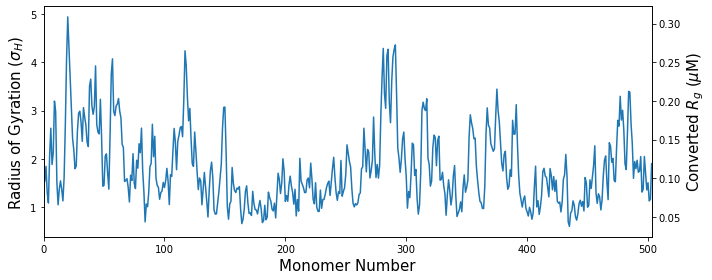

In [735]:
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(rgpb_2)
ax1.set_xlim(0,len(rgpb_2)-1)

ax2 = ax1.twinx() 

ax2.plot(np.asarray(rgpb_2)*(1/16),alpha=0)
ax2.set_ylabel('Converted $R_{g}$ ($\mu$M)', size=15)

ax1.set_xlabel('Monomer Number',size=15)
ax1.set_ylabel('Radius of Gyration ($\sigma_{H}$)', size=15)
fig.tight_layout()

plt.savefig('rg_mnn_normalsize.png', dpi=300)